# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry with a gravity inversion for a portion of the Ross Sea. We create a synthetic gravity dataset which is the forward gravity of 3 density contrasts across real topographic surfaces. The first is the air-water surface, from BedMap2. The second is the water-sediment (bathymetry) surface, also from BedMap2. The third is the sediment-basement, from the ANTOSTRAT seismic surveys. We use three version of this synthetic observed gravity; 1) a "perfect" gravity survey at a constant 1000m above sea level, which stations evenly spacing in a 2km grid over the region, with and without 2% gaussian noise added, 2) a resampled gravity survey at 10km spacing, with and with 2% noise, and 3) a synthetic airborne survey, with N-S and E-W flight lines at a constant 1000m altitude, with several gaps between lines. We create a low-resolution bathymetry by samping the true bathymetry at 110 random "constraint" points, and regridding the surface with just these values. In an Antarctic setting, these points represent single seismic survey locations which image the bathymetry surface.

All of these processes are included in the notebook `Ross_Sea_synthetic_model.ipynb`.  While not included as a layer in the inversion, the forward gravity of the basement is included in the observed gravity. This field represents the regional gravity signal from factors such as long wavelength crustal thickness variations. 

import packages

In [37]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib
import string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


# Load data

## topographic layers
* full resolution bed 
* low resolution bed

In [38]:
bed = xr.open_zarr("../synthetic_data/Ross_Sea_bed.zarr").z

starting_bed = xr.open_zarr("../synthetic_data/Ross_Sea_lowres_bed_semiregular.zarr").z

print(utils.get_grid_info(bed))
print(utils.get_grid_info(starting_bed))
starting_bed

(5000.0, [-80000.0, 320000.0, -1840000.0, -1340000.0], -1277.04309082, 1291.859375, 'g')
(5000.0, [-80000.0, 320000.0, -1840000.0, -1340000.0], -1277.04309082, 1291.859375, 'g')


<xarray.DataArray 'z' (northing: 101, easting: 81)>
dask.array<open_dataset-2df7baa207fad42e9adf42122eaf6222z, shape=(101, 81), dtype=float64, chunksize=(101, 81), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -8e+04 -7.5e+04 -7e+04 ... 3.15e+05 3.2e+05
  * northing  (northing) float64 -1.84e+06 -1.835e+06 ... -1.345e+06 -1.34e+06
Attributes:
    metadata:  Generated by Spline()

## gravity data
* airborne survey gravity data
* full resolution forward gravity of the regional field (basement)

In [114]:
# true regional gravity anomaly
true_regional_grav = xr.open_zarr(
    "../synthetic_data/Ross_Sea_forward_grav.zarr"
).basement

# airborne survey gravity point data
grav_df = pd.read_csv(
    # "../synthetic_data/Ross_Sea_airborne_survey_gravity.csv.gz",
    "../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_df

northing   easting   basement  bathymetry  forward_total  upward
0    -1800000.0  -40000.0  11.347847   -1.169473      10.178373  1000.0
1    -1800000.0  -35000.0  12.022782    3.592784      15.615567  1000.0
2    -1800000.0  -30000.0  12.592603    5.341447      17.934051  1000.0
3    -1800000.0  -25000.0  13.024391    4.314322      17.338714  1000.0
4    -1800000.0  -20000.0  13.288657    3.793990      17.082646  1000.0
...         ...       ...        ...         ...            ...     ...
5520 -1380000.0  260000.0  -7.248773  -20.194754     -27.443527  1000.0
5521 -1380000.0  265000.0  -9.924521  -21.042237     -30.966758  1000.0
5522 -1380000.0  270000.0 -12.719607  -21.589889     -34.309496  1000.0
5523 -1380000.0  275000.0 -15.504155  -22.009418     -37.513572  1000.0
5524 -1380000.0  280000.0 -18.144860  -21.951437     -40.096297  1000.0

[5525 rows x 6 columns]

# Set region and parameters

Use the same regions and parameters as `Ross_Sea synthetic_model.ipynb`

In [107]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(bed)

# set gravity observation parameters
grav_spacing = layer_spacing

inversion_region = vd.pad_region(buffer_region, pad=-40e3)

# set density contrast
density = 2300 - 1030

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  (-40000.0, 280000.0, -1800000.0, -1380000.0)
buffer region =  [-80000.0, 320000.0, -1840000.0, -1340000.0]


# Prep grav data
## grav data

In [115]:
grav_df = inv_utils.prep_grav_data(
    grav_df,
    region=inversion_region,
    # input_grav_name="Gobs_noise",
    input_grav_name="forward_total",
    input_coord_names=("easting", "northing", "upward"),
)

print(f"Gravity data: {len(grav_df)} points")

print(f"gravity avg. elevation: {int(np.nanmean(grav_df.upward))}")

Gravity data: 5525 points
gravity avg. elevation: 1000


## constraint points

In [116]:
# load constraint points into a dataframe
constraints_all = pd.read_csv(
    "../synthetic_data/Ross_Sea_synthetic_constraints_semiregular.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraints = utils.points_inside_region(
    constraints_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraints)}")
constraints.head()

bathymetry control points:1060


northing  easting  inside      upward
656 -1800000.0 -40000.0   False -573.472778
657 -1800000.0 -35000.0   False -451.209564
658 -1800000.0 -30000.0   False -421.105225
659 -1800000.0 -25000.0   False -460.030060
660 -1800000.0 -20000.0   False -479.603577

## Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution bathymetry density contrast. This will be the input into our inversion.


## Bed prisms

In [117]:
# create prisms around low-res bathymetry
# positive densities above reference, negative below
print(f"Bathymetry density contrast: {density}kgm-3")

bed_prisms = inv_utils.grids_to_prisms(
    surface=starting_bed,
    reference=starting_bed.values.mean(),
    density=xr.where(starting_bed >= starting_bed.values.mean(), density, -density),
)

# plotting.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Bathymetry density contrast: 1270kgm-3


## Bed gravity

In [118]:
# calculate gravity of layer1
bed_grav_grid, bed_grav_df = inv_utils.forward_grav_of_prismlayer(
    [bed_prisms],
    grav_df,
    names=["bed_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

grav_df["bed_forward"] = bed_grav_df.forward_total

grav_df

  0%|                                                  | 0/5525 [00:00<?, ?it/s]

northing   easting   basement  bathymetry       Gobs  upward  \
0    -1800000.0  -40000.0  11.347847   -1.169473  10.178373  1000.0   
1    -1800000.0  -35000.0  12.022782    3.592784  15.615567  1000.0   
2    -1800000.0  -30000.0  12.592603    5.341447  17.934051  1000.0   
3    -1800000.0  -25000.0  13.024391    4.314322  17.338714  1000.0   
4    -1800000.0  -20000.0  13.288657    3.793990  17.082646  1000.0   
...         ...       ...        ...         ...        ...     ...   
5520 -1380000.0  260000.0  -7.248773  -20.194754 -27.443527  1000.0   
5521 -1380000.0  265000.0  -9.924521  -21.042237 -30.966758  1000.0   
5522 -1380000.0  270000.0 -12.719607  -21.589889 -34.309496  1000.0   
5523 -1380000.0  275000.0 -15.504155  -22.009418 -37.513572  1000.0   
5524 -1380000.0  280000.0 -18.144860  -21.951437 -40.096297  1000.0   

      bed_forward  
0       -0.859487  
1        3.902787  
2        5.651362  
3        4.624069  
4        4.103520  
...           ...  
5520   -19.886670  
5521   -20.733905  
5522   -21.281371  
5523   -21.700790  
5524   -21.642794  

[5525 rows x 7 columns]

# Misfit

In [111]:
# grav_df = inv.misfit(
#     input_grav=grav_df,
#     input_forward_column="bed_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )

### Save and load results

In [46]:
grav_df.to_csv(
    "../synthetic_data/Ross_Sea_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [47]:
grav_df = pd.read_csv(
    "../synthetic_data/Ross_Sea_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav_df

northing   easting  predicted_grav       Gobs  upward  bed_forward
0    -1800000.0  -40000.0       11.598446  12.260800  1000.0    -0.859487
1    -1800000.0  -35000.0       16.064631  16.219463  1000.0     3.902787
2    -1800000.0  -30000.0       18.862281  19.232410  1000.0     5.651362
3    -1800000.0  -25000.0       18.091392  18.931185  1000.0     4.624069
4    -1800000.0  -20000.0       16.644949  17.345819  1000.0     4.103520
...         ...       ...             ...        ...     ...          ...
5520 -1380000.0  260000.0      -26.405825 -26.891765  1000.0   -19.886670
5521 -1380000.0  265000.0      -29.991817 -29.925102  1000.0   -20.733905
5522 -1380000.0  270000.0      -31.949737 -32.176367  1000.0   -21.281371
5523 -1380000.0  275000.0      -32.128447 -32.398519  1000.0   -21.700790
5524 -1380000.0  280000.0      -30.562464 -30.505846  1000.0   -21.642794

[5525 rows x 6 columns]

In [48]:
# plotting.misfit_plotting(
#     grav_df,
#     plot_type="pygmt",
#     input_forward_column="bed_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints[constraints.inside].rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

In [49]:
# # plot layer 2 gravity
# fig = maps.plot_grd(
#     grid=bed_forward,
#     fig_height=10,
#     cmap="vik",
#     region=inversion_region,
#     title="Bathymetry forward gravity",
#     cbar_unit="mGal",
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# # plot layer 2 topography
# fig = maps.plot_grd(
#     grid=starting_bed,
#     fig_height=10,
#     cmap="rain",
#     reverse_cpt=True,
#     region=inversion_region,
#     grd2cpt=True,
#     title="Low-resolution bathymetry",
#     cbar_label="elevation",
#     cbar_unit="m",
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraints[constraints.inside].rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# fig.show()

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we created the synthetic model, we precisely know the regional component (the forward gravity of the `basement`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

[I 2023-04-19 18:42:05,449] A new study created in Journal with name: Ross_Sea_region_sep_indiv_filter_regional_comparison


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-04-19 18:42:26,980] A new study created in Journal with name: Ross_Sea_region_sep_indiv_trend_regional_comparison


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-04-19 18:42:46,612] A new study created in Journal with name: Ross_Sea_region_sep_indiv_constraints_regional_comparison


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-04-19 18:43:06,269] A new study created in Journal with name: Ross_Sea_region_sep_indiv_eq_sources_regional_comparison


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]


########## filter ##########
number                                       17
value                                  5.472871
datetime_start       2023-04-19 18:42:16.000250
datetime_complete    2023-04-19 18:42:24.989917
duration                 0 days 00:00:08.989667
params_filter                             50000
state                                  COMPLETE
Name: 17, dtype: object
DC shifted observed gravity by 5.45mGal to match forward gravity.


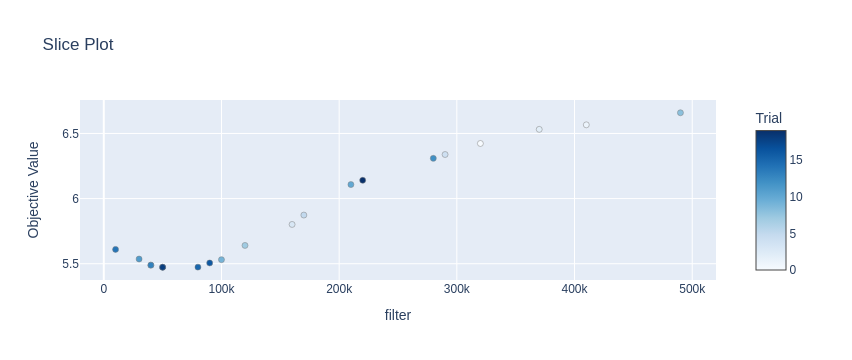


########## trend ##########
number                                        7
value                                  5.284145
datetime_start       2023-04-19 18:42:27.016825
datetime_complete    2023-04-19 18:42:33.769931
duration                 0 days 00:00:06.753106
params_trend                                  9
state                                  COMPLETE
Name: 7, dtype: object
DC shifted observed gravity by 5.45mGal to match forward gravity.


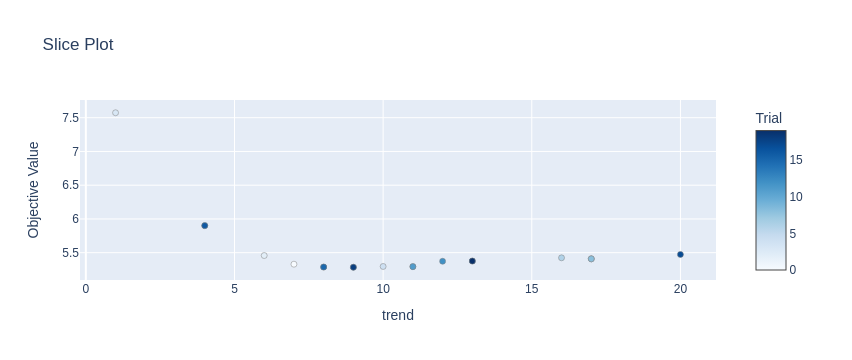


########## constraints ##########
number                                         3
value                                   5.753988
datetime_start        2023-04-19 18:42:46.714180
datetime_complete     2023-04-19 18:42:48.659197
duration                  0 days 00:00:01.945017
params_constraints                           0.0
state                                   COMPLETE
Name: 3, dtype: object
DC shifted observed gravity by 5.45mGal to match forward gravity.


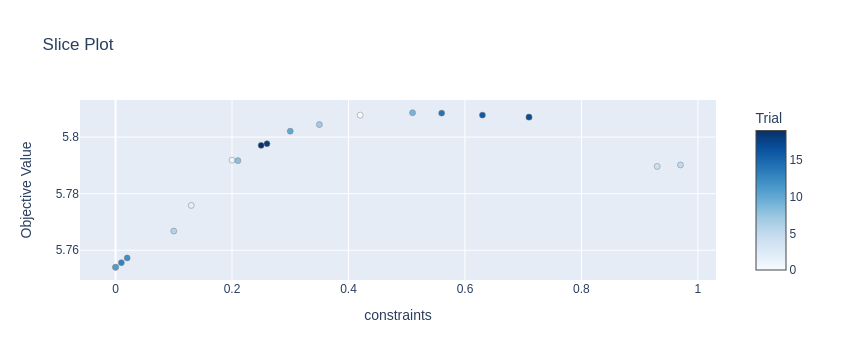


########## eq_sources ##########
number                                        0
value                                  3.298679
datetime_start       2023-04-19 18:43:06.285059
datetime_complete    2023-04-19 18:43:41.883506
duration                 0 days 00:00:35.598447
params_eq_sources                       1980000
state                                  COMPLETE
Name: 0, dtype: object
DC shifted observed gravity by 5.45mGal to match forward gravity.


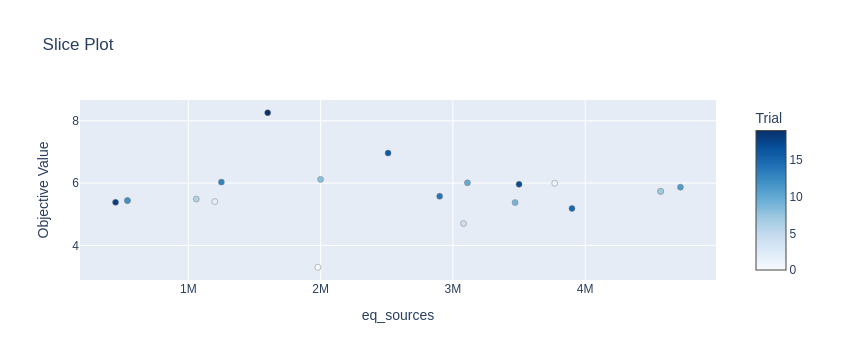

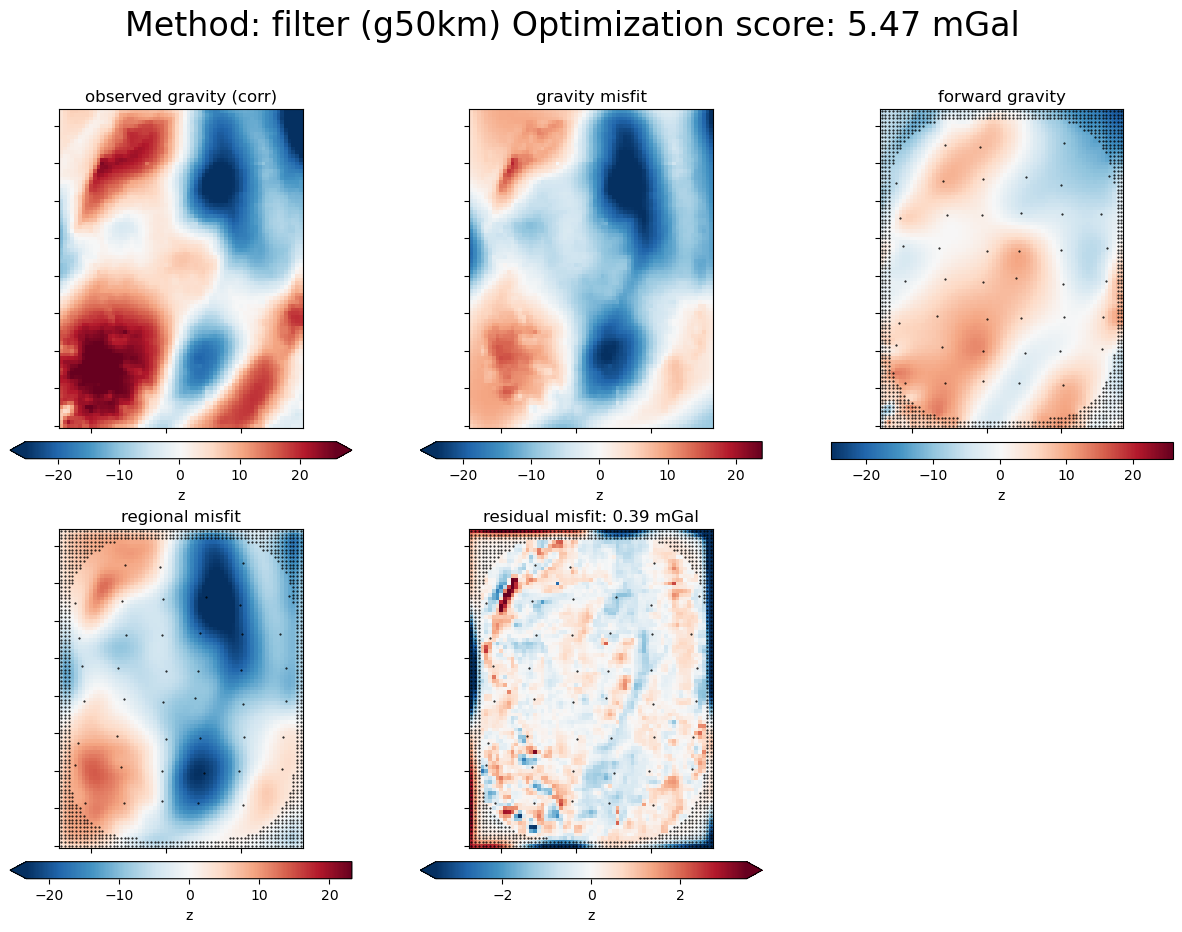

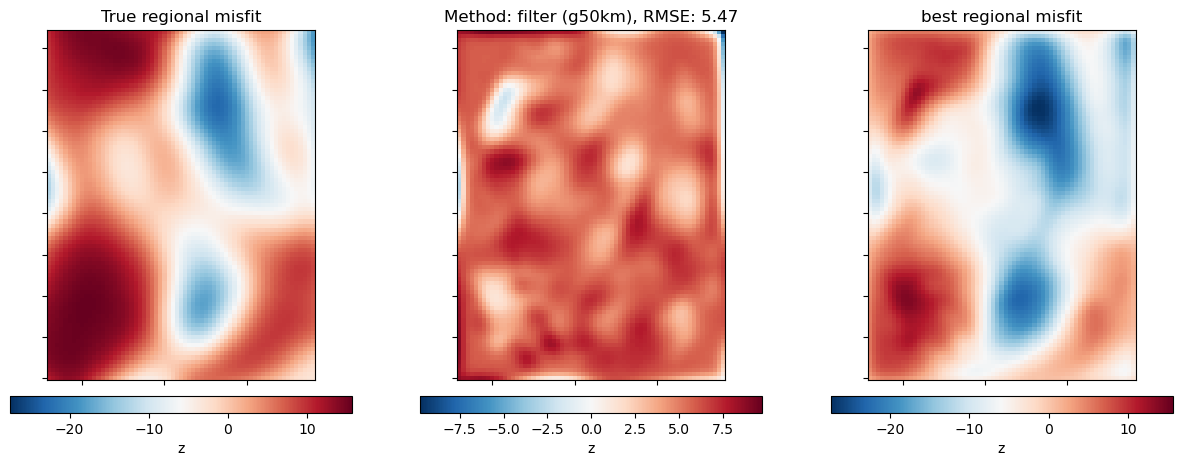

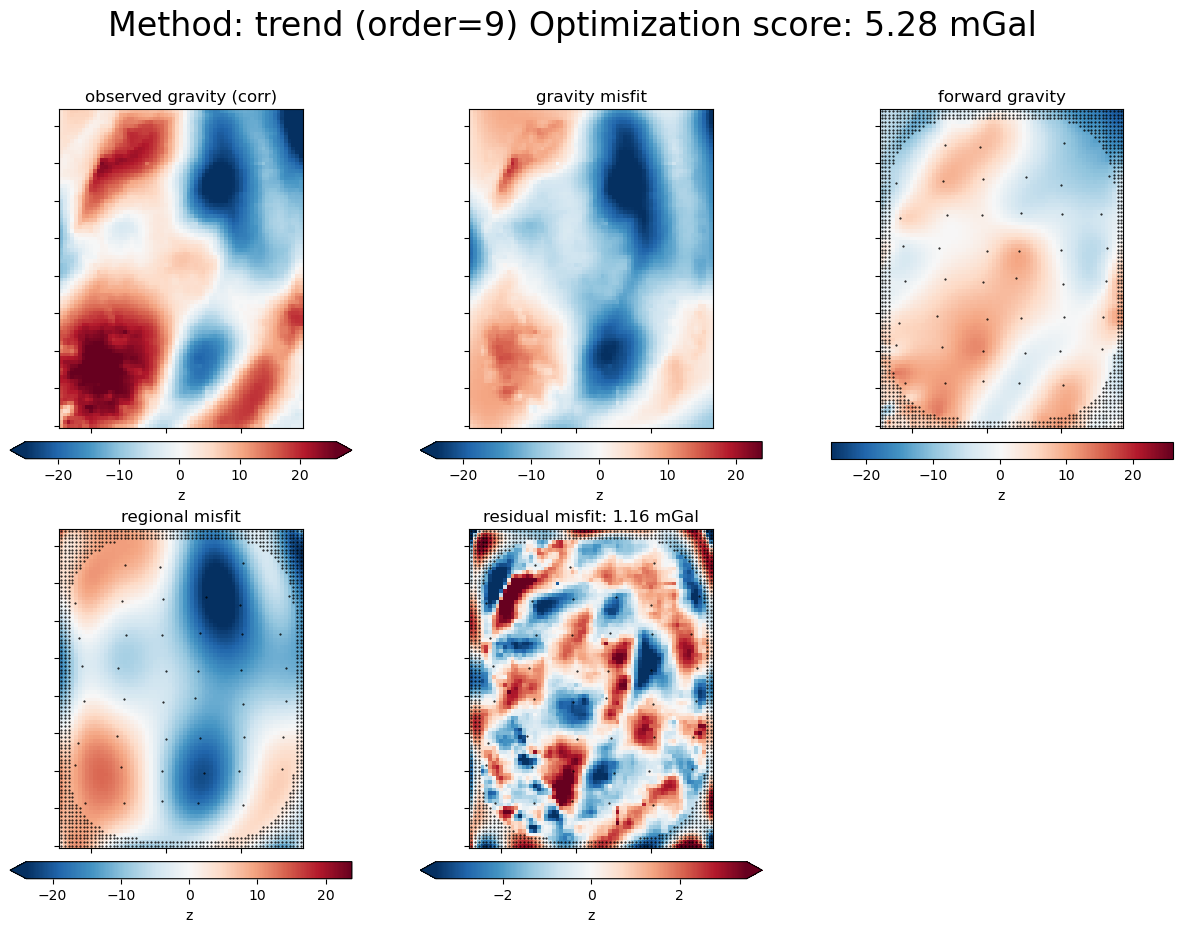

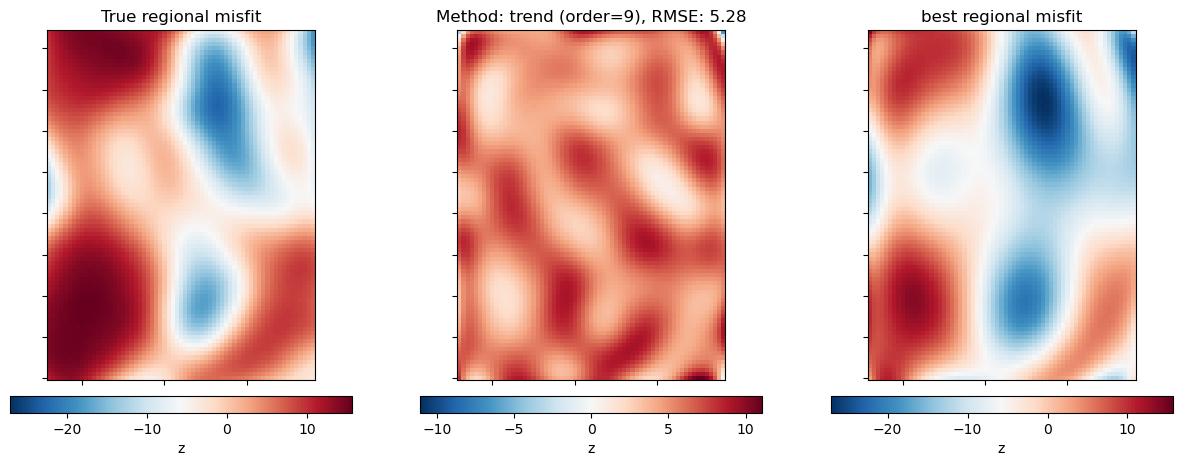

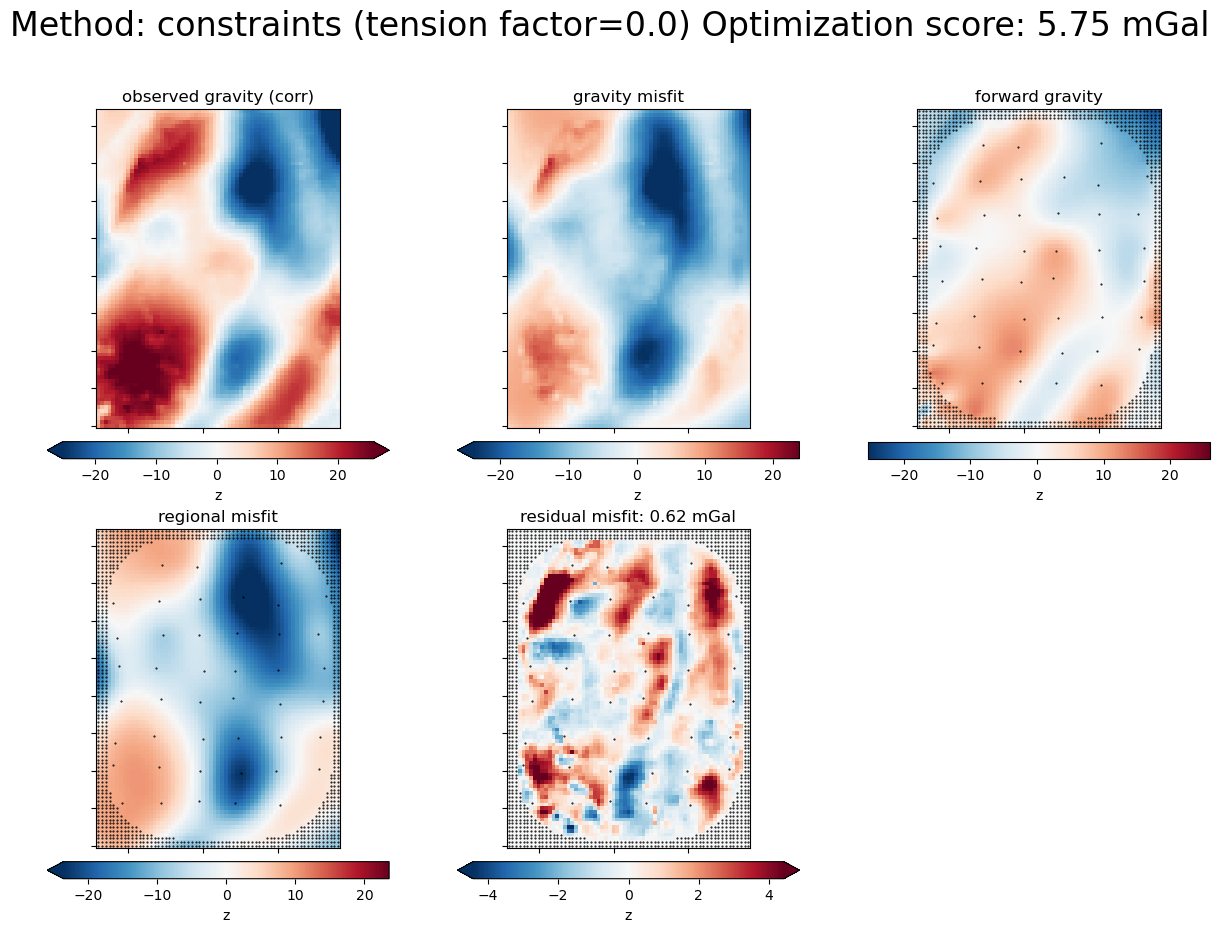

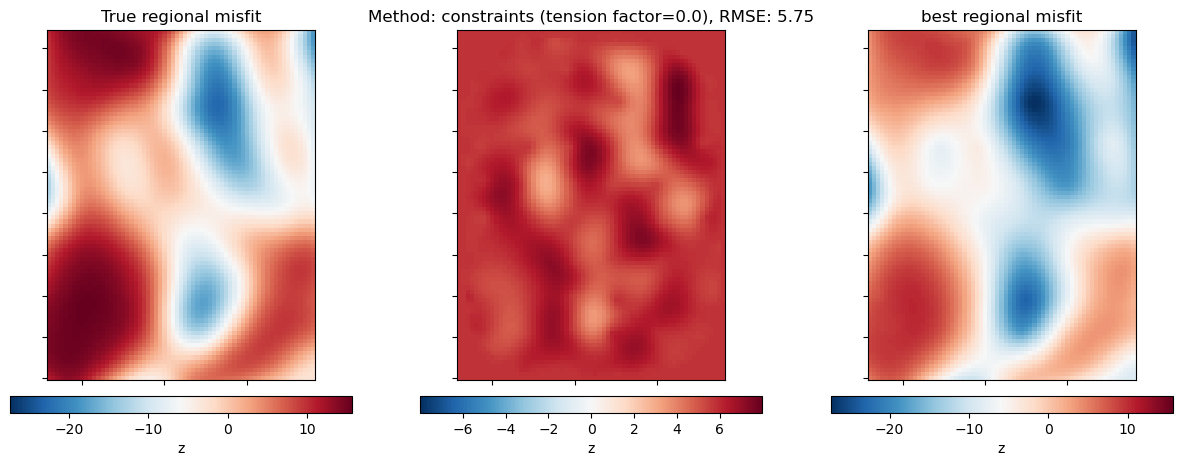

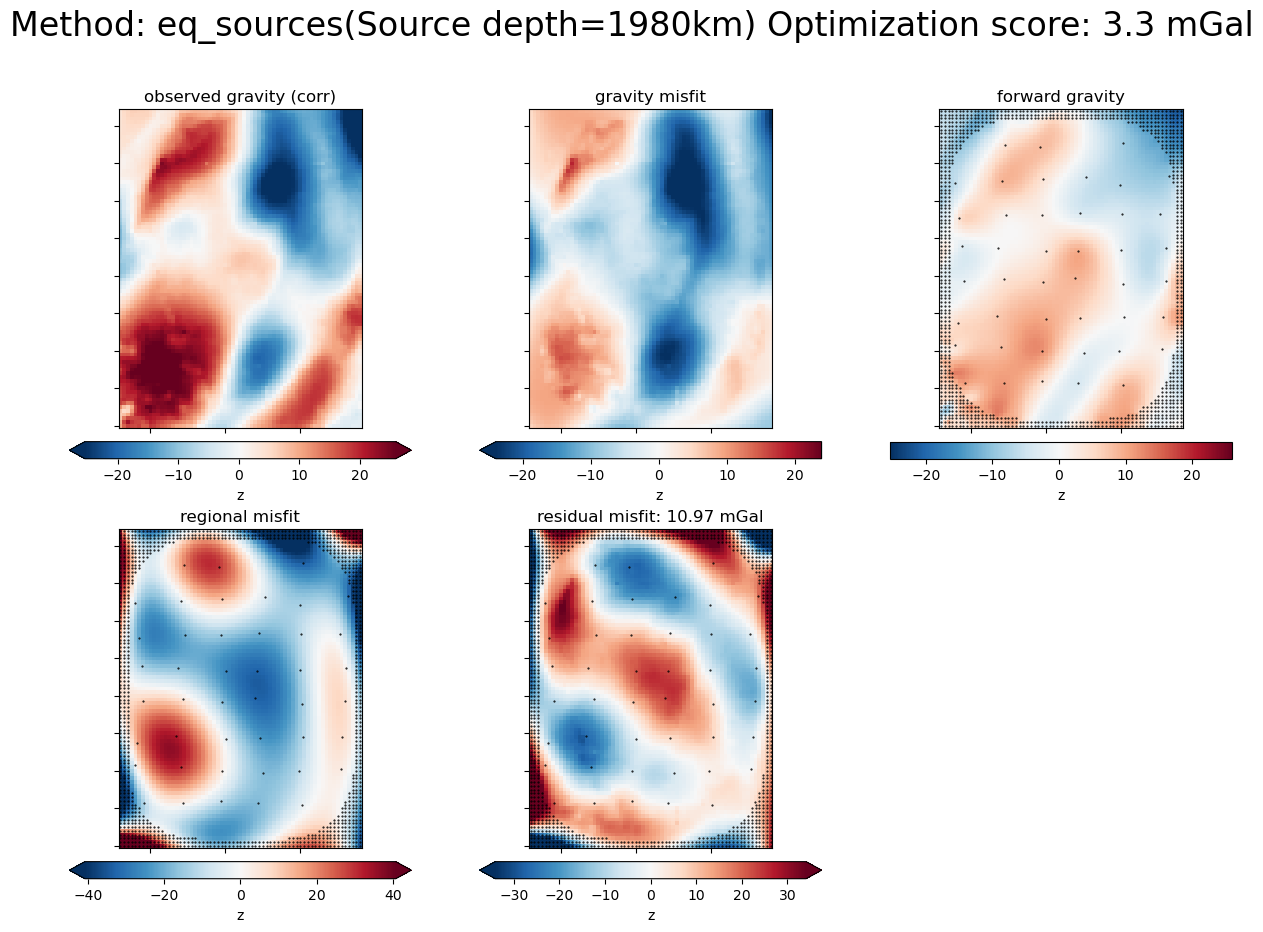

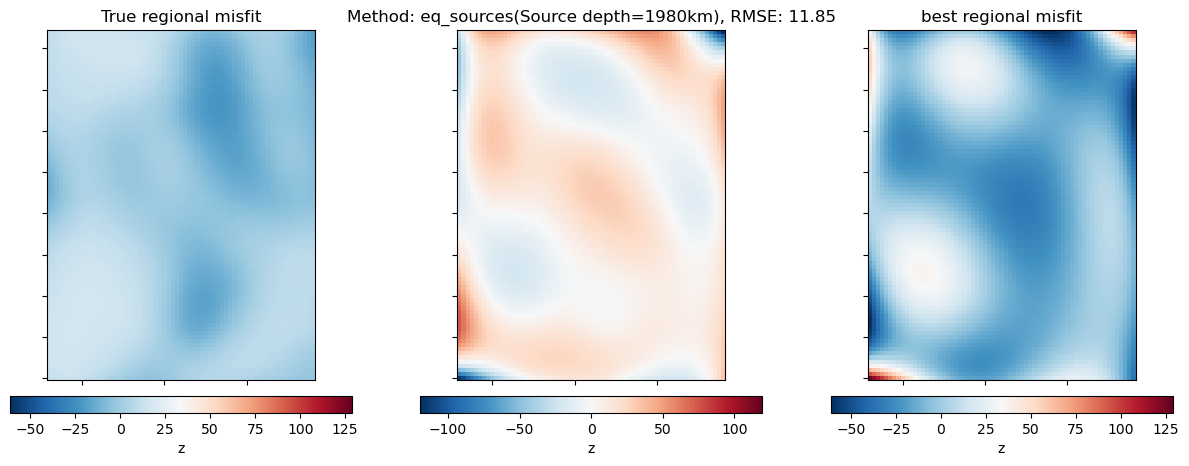

In [119]:
regional_kwargs = dict(
    input_grav=grav_df,
    input_forward_column="bed_forward",
    input_grav_column="Gobs",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_regional_grav,
    constraints=constraints,
)

# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

for i in methods:
    # set name and storage for the optimization
    study_name = f"Ross_Sea_region_sep_indiv_{i}_{comparison_method}"
    fname = f"../optimization_logs/{study_name}.log"

    # remove if exists
    pathlib.Path(fname).unlink(missing_ok=True)
    pathlib.Path(f"{fname}.lock").unlink(missing_ok=True)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="JournalStorage is experimental")
        storage = JournalStorage(JournalFileStorage(fname))

    # set number of runs per method
    n_trials = 20

    # define search space if using GridSampler
    # search_space = {
    #     "damping": np.arange(-6, 1, step=2, dtype="float"),
    #     # "weights_inner": np.arange(1e3, 1900, step=100),
    #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
    # }
    # create study
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="BoTorch")
        study = optuna.create_study(
            study_name=study_name,
            storage=storage,
            direction="minimize",
            # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
            sampler=optuna.integration.BoTorchSampler(
                n_startup_trials=int(n_trials / 3)
            ),
            # sampler=optuna.samplers.GridSampler(search_space),
            load_if_exists=True,
        )

    # define the objective function
    objective = optimization.optimal_regional_params(
        comparison_method=comparison_method,
        regional_method=i,
        filter_limits=[10e3, 500e3, 10e3],  # 100 options
        trend_limits=[1, 20, 1],  # 20 options
        constraints_limits=[0, 1, 0.01],  # 101 options
        eq_sources_limits=[10e3, 5000e3, 10e3],  # 1000 options
        **regional_kwargs,
    )

    # run the optimization
    with inv_utils.HiddenPrints():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            study, study_df = optimization.optuna_parallel(
                study_name=study_name,
                study_storage=storage,
                objective=objective,
                n_trials=n_trials,
                maximize_cpus=True,
                parallel=True,
            )

# load studies
study_dfs = []
for i in methods:
    study_name = f"Ross_Sea_region_sep_indiv_{i}_{comparison_method}"
    fname = f"../optimization_logs/{study_name}.log"

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="JournalStorage is experimental")
        storage = JournalStorage(JournalFileStorage(fname))

    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    plotting.plot_best_param(
        study_df, comparison_method, regional_method=i, **regional_kwargs
    )
    optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [124]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
60       0  3.298679 2023-04-19 18:43:06.285059 2023-04-19 18:43:41.883506   
64       4  4.701346 2023-04-19 18:43:06.288425 2023-04-19 18:43:19.017470   
75      15  5.185083 2023-04-19 18:43:06.299865 2023-04-19 18:43:51.740967   
27       7  5.284145 2023-04-19 18:42:27.016825 2023-04-19 18:42:33.769931   
38      18  5.284145 2023-04-19 18:42:27.044965 2023-04-19 18:42:45.188693   

                 duration  params_filter     state params_method  \
60 0 days 00:00:35.598447            NaN  COMPLETE    eq_sources   
64 0 days 00:00:12.729045            NaN  COMPLETE    eq_sources   
75 0 days 00:00:45.441102            NaN  COMPLETE    eq_sources   
27 0 days 00:00:06.753106            NaN  COMPLETE         trend   
38 0 days 00:00:18.143728            NaN  COMPLETE         trend   

    params_trend  params_constraints  params_eq_sources  
60           NaN                 NaN          1980000.0  
64           NaN                 NaN          3080000.0  
75           NaN                 NaN          3900000.0  
27           9.0                 NaN                NaN  
38           9.0                 NaN                NaN

In [125]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best filter: index {best_filter}")
print(f"best trend: index {best_trend}")
print(f"best constraints: index {best_constraints}")
print(f"best eq sources: index {best_eq_sources}")

best filter: index 18
best trend: index 7
best constraints: index 3
best eq sources: index 0


In [126]:
regional_method = df.iloc[0].params_method
print(f"best method: {regional_method}")

param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]
print(f"best parameter: {param}")

best method: eq_sources
best parameter: 1980000.0


In [54]:
# grids=[]
# difs =[]
# titles=[]
# for i in methods:
#     param = df[df[f"params_{i}"].notnull()].iloc[0][f"params_{i}"]
#     df_anomalies = regional.regional_seperation(
#         regional_method=i,
#         filter=f"g{param}",
#         trend=int(param),
#         fill_method="pygmt",
#         tension_factor=param,
#         eq_sources=param,
#         **regional_kwargs,
#     )
#     grid = df_anomalies.set_index(["northing","easting"]).to_xarray().reg
#     dif = true_regional_grav-grid
#     rms = utils.RMSE(dif)
#     title = f"{i.capitalize()}, RMSE: {round(rms,2)} mGal"
#     grids.append(grid)
#     difs.append(dif)
#     titles.append(title)

In [55]:
# lims = utils.get_min_max(true_regional_grav)

# fig = maps.plot_grd(
#     true_regional_grav,
#     # fig_height=10,
#     # cmap="vik",
#     title="True regional component",
#     region=inversion_region,
#     # hist=True,
#     cbar_yoffset=2,
#     cbar_label="mGal",
#     cpt_lims=lims,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="20p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# for i, g in enumerate(grids):
#     if i == 0:
#         origin_shift = "both_shift"
#         xshift_amount = -.5
#         yshift_amount = -1.15
#     elif i == 1:
#         origin_shift = "xshift"
#         xshift_amount = 1
#     elif i == 2:
#         origin_shift = "yshift"
#         yshift_amount = -1.15
#     elif i == 3:
#         origin_shift = "xshift"
#         xshift_amount = -1

#     fig = maps.plot_grd(
#         g,
#         points = constraints[constraints.inside].rename(columns={"easting":"x","northing":"y"}),
#         points_style = "c0.1c",
#         fig=fig,
#         # fig_height=10,
#         # cmap="vik",
#         cpt_lims=lims,
#         title=titles[i],
#         region=inversion_region,
#         # hist=True,
#         cbar_label="mGal",
#         cbar_yoffset=2,
#         origin_shift=origin_shift,
#         xshift_amount=xshift_amount,
#         yshift_amount=yshift_amount,
#     )
#     fig.text(
#         position="TL",
#         justify="BL",
#         text=f"{string.ascii_lowercase[i+1]})",
#         font="20p,Helvetica,black",
#         offset="j0/.3",
#         no_clip=True,
#     )

# fig.show()

In [56]:
# # lims = utils.get_min_max(true_regional_grav)

# fig = maps.plot_grd(
#     true_regional_grav,
#     # fig_height=10,
#     # cmap="vik",
#     title="True regional component",
#     region=inversion_region,
#     # hist=True,
#     cbar_yoffset=2,
#     cbar_label="mGal",
#     # cpt_lims=lims,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="20p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# for i, g in enumerate(difs):
#     if i == 0:
#         origin_shift = "both_shift"
#         xshift_amount = -.5
#         yshift_amount = -1.15
#     elif i == 1:
#         origin_shift = "xshift"
#         xshift_amount = 1
#     elif i == 2:
#         origin_shift = "yshift"
#         yshift_amount = -1.15
#     elif i == 3:
#         origin_shift = "xshift"
#         xshift_amount = -1

#     fig = maps.plot_grd(
#         g,
#         points = constraints[constraints.inside].rename(columns={"easting":"x","northing":"y"}),
#         points_style = "c0.1c",
#         fig=fig,
#         # fig_height=10,
#         cmap="vik+h0",
#         # cpt_lims=lims,
#         title=titles[i],
#         region=inversion_region,
#         # hist=True,
#         cbar_label="mGal",
#         cbar_yoffset=2,
#         origin_shift=origin_shift,
#         xshift_amount=xshift_amount,
#         yshift_amount=yshift_amount,
#     )
#     fig.text(
#         position="TL",
#         justify="BL",
#         text=f"{string.ascii_lowercase[i+1]})",
#         font="20p,Helvetica,black",
#         offset="j0/.3",
#         no_clip=True,
#     )

# fig.show()

In [57]:
# for i in methods:

#     param = df[df[f"params_{i}"].notnull()].iloc[0][f"params_{i}"]

#     df_anomalies = regional.regional_seperation(
#         regional_method=i,
#         filter=f"g{param}",
#         trend=int(param),
#         fill_method="pygmt",
#         tension_factor=param,
#         eq_sources=param,
#         depth_type="relative",
#         eq_damping=None,
#         block_size=grav_spacing,
#         **regional_kwargs,
#     )

#     _ = utils.grd_compare(
#         regional_kwargs.get("true_regional"),
#         df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#         grid1_name="True regional gravity",
#         grid2_name="Calculated regional gravity",
#         title=f"Method: {i}",
#         plot=True,
#         region=inversion_region,
#         plot_type="pygmt",
#         cmap="vik",
#         diff_cmap="vik+h0",
#         hist=True,
#         inset=False,
#         points_style="c.15c",
#         subplot_labels=True,
#         # robust=True,
#         robust=False,
#         verbose="q",
#         cbar_label="mGal",
#     )

method: constraints, parameter: 0.0
DC shifted observed gravity by 5.45mGal to match forward gravity.


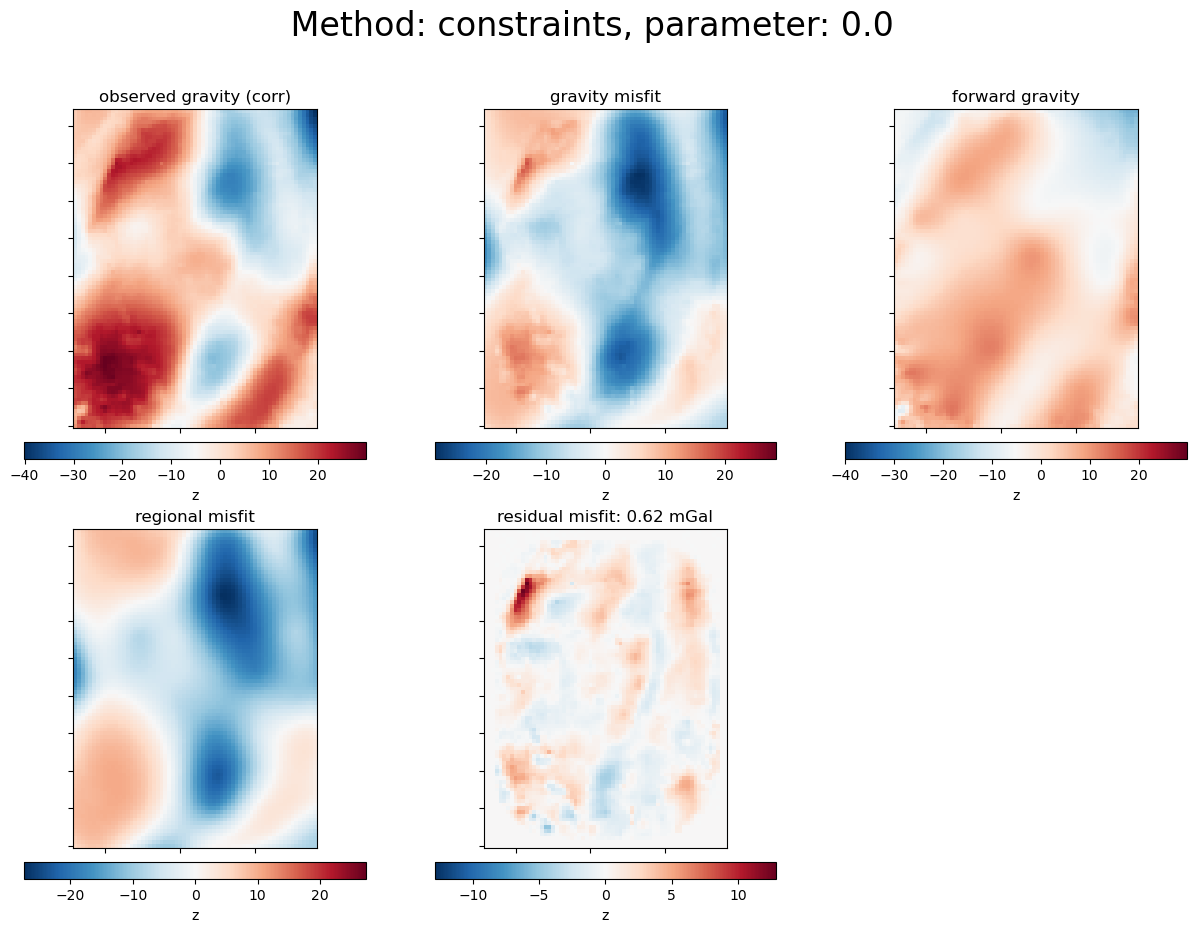

In [127]:
regional_kwargs = dict(
    input_grav=grav_df,
    input_forward_column="bed_forward",
    input_grav_column="Gobs",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_regional_grav,
    constraints=constraints,
)

# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# param = .25

# get best param from chosen method.
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

print(f"method: {regional_method}, parameter: {param}")

df_anomalies = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=int(param),
    tension_factor=param,
    eq_sources=param,
    **regional_kwargs,
)

anom_grids = plotting.anomalies_plotting(
    df_anomalies,
    region=inversion_region,
    grav_spacing=grav_spacing,
    title=f" Method: {regional_method}, parameter: {param}",
    title_font="16p,Helvetica-Bold",
    # constraints=constraints[constraints.inside].rename(columns={"easting":"x","northing":"y"}),
    input_forward_column="bed_forward",
    input_grav_column="Gobs",
    # plot_type="pygmt",
    plot_type="xarray",
    robust=False,
)

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     title_font="16p,Helvetica-Bold",
#     plot=True,
#     region=regional_kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

# Constraints grid

In [91]:
starting_prisms = copy.deepcopy(bed_prisms)

weights, min_dist = inv_utils.constraints_grid(
    constraints,
    starting_prisms,
    inner_bound=layer_spacing,
    outer_bound=15e3,
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
    efficient_interp=True,
)
starting_prisms["weights"] = weights
starting_prisms["min_dist"] = min_dist

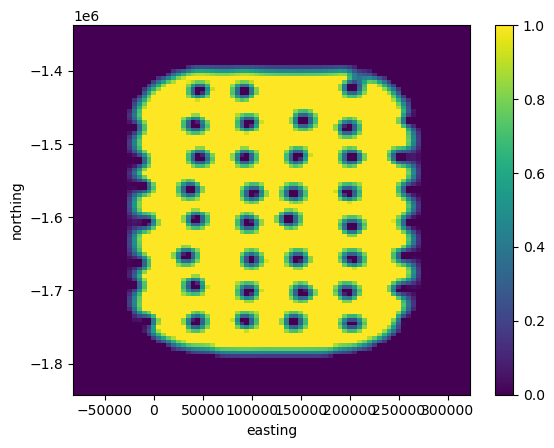

In [92]:
weights.plot()

### Save to Zarr

In [61]:
enc = {x: {"compressor": zarr.Blosc()} for x in starting_prisms}
starting_prisms.to_zarr(
    "../synthetic_data/Ross_Sea_starting_prisms.zarr",
    encoding=enc,
    mode="w",
)

In [62]:
starting_prisms = xr.open_zarr("../synthetic_data/Ross_Sea_starting_prisms.zarr")

In [63]:
# fig = maps.plot_grd(
#     starting_prisms.weights,
#     fig_height=10,
#     region=inversion_region,
#     title="Weighting grid",
#     title_font="16p,Helvetica-Bold",
#     cbar_label="weights",
#     cmap="dense",
#     # points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.05c",
# )
# fig = maps.plot_grd(
#     starting_prisms.min_dist,
#     fig=fig,
#     region=inversion_region,
#     origin_shift="xshift",
#     title="Minumum distance to constraints",
#     title_font="16p,Helvetica-Bold",
#     cbar_label="m",
#     cmap="viridis",
#     # points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.05c",
# )

# fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration


############################################################
iteration 1
Layer correction median: -0.0134 m, RMSE:0.402 m
updated misfit RMSE: 0.5553
updated L2-norm: 0.7452,  tolerance: 0.2
updated delta L2-norm : 1.0598,  tolerance: 1.01

############################################################
iteration 2
Layer correction median: -0.0108 m, RMSE:0.3588 m
updated misfit RMSE: 0.5034
updated L2-norm: 0.7095,  tolerance: 0.2
updated delta L2-norm : 1.0503,  tolerance: 1.01

############################################################
iteration 3
Layer correction median: -0.0087 m, RMSE:0.3252 m
updated misfit RMSE: 0.4524
updated L2-norm: 0.6726,  tolerance: 0.2
updated delta L2-norm : 1.0548,  tolerance: 1.01

############################################################
iteration 4
Layer correction median: -0.0068 m, RMSE:0.2889 m
updated misfit RMSE: 0.4062
updated L2-norm: 0.6373,  tolerance: 0.2
updated delta L2-norm : 1.0553,  tolerance: 1.01

################################

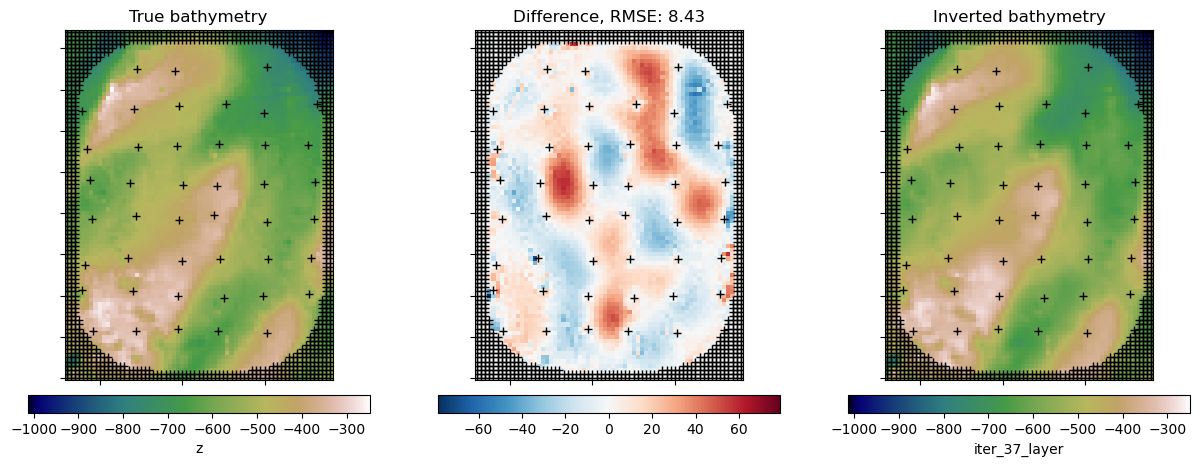

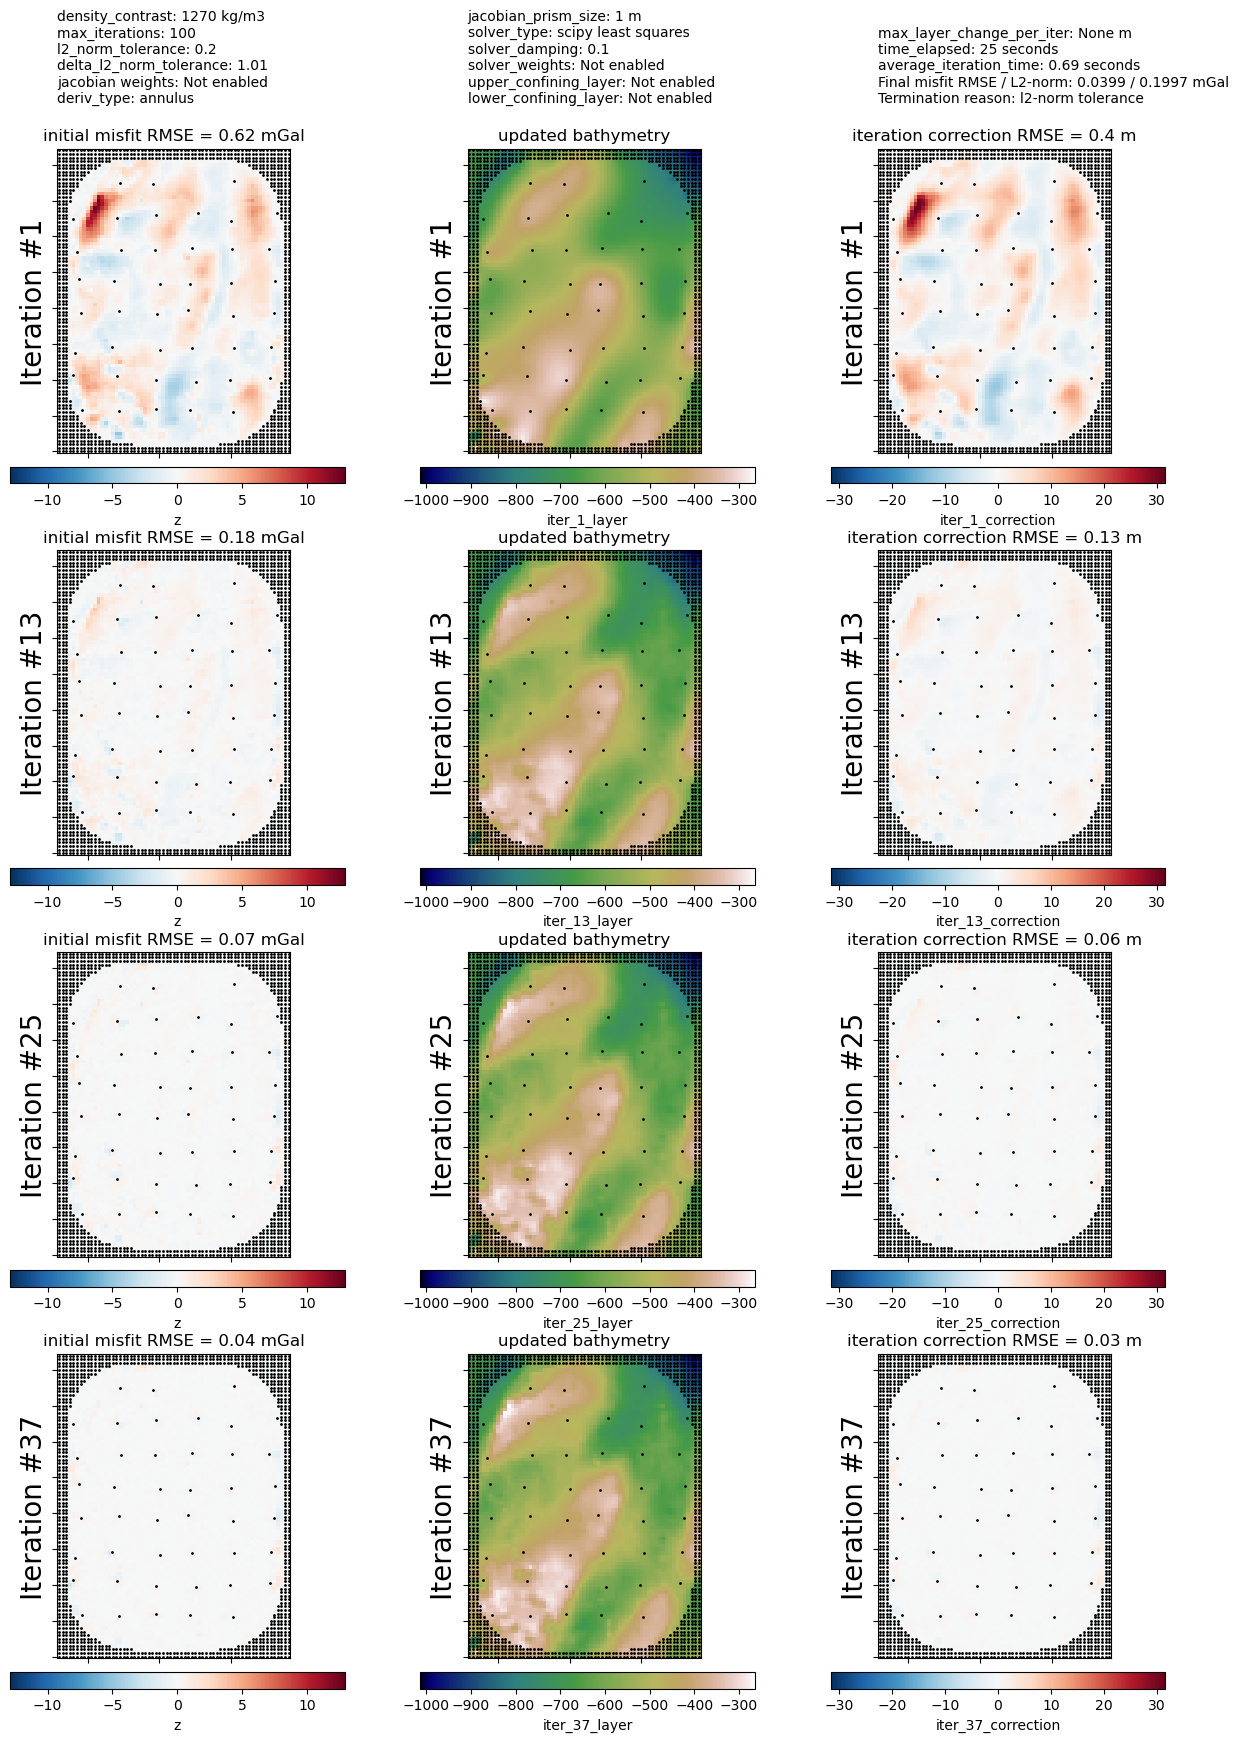

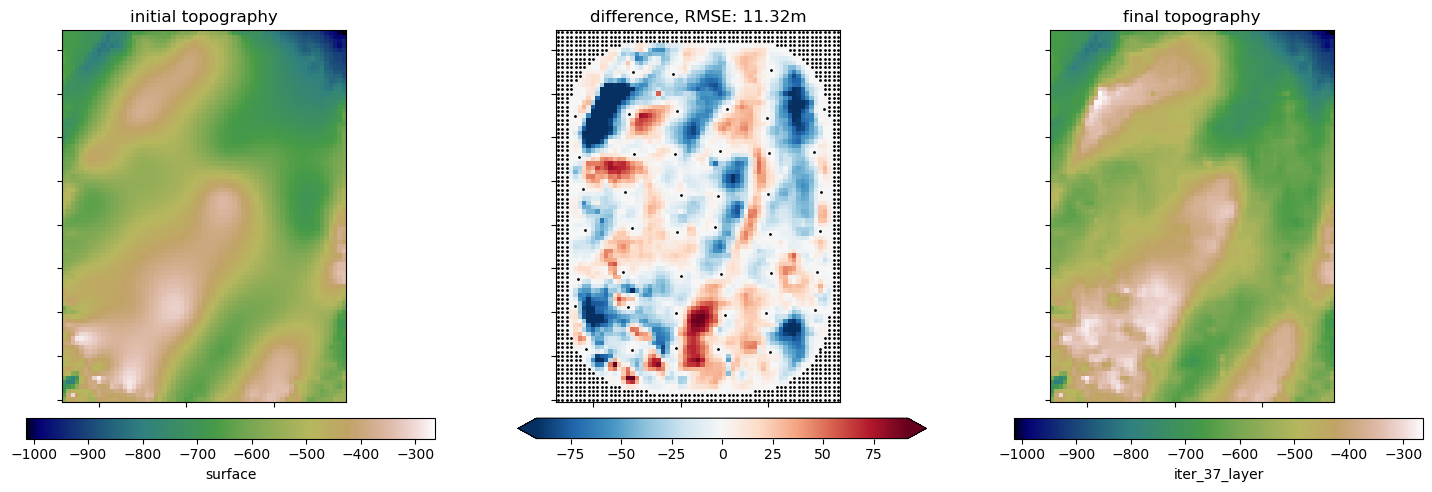

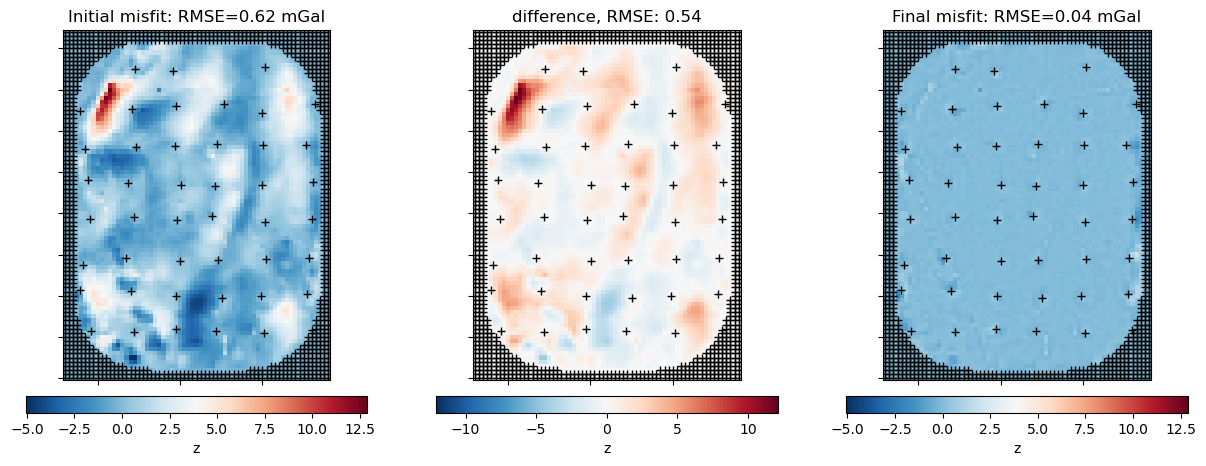

In [128]:
# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least .5%
    # apply_weights = True,
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    solver_damping=10**-1,
)

results = inv.inversion_RMSE(
    input_grav=df_anomalies,
    inversion_region=inversion_region,
    true_surface=bed,
    constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
    plot=True,
    plot_type="xarray",
    **kwargs,
)

(
    rmse,
    prism_results,
    grav_results,
    params,
    elapsed_time,
    constraints_rmse,
) = results

_ = plotting.plot_inversion_results(
    grav_results,
    prism_results,
    params,
    grav_region=inversion_region,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    iters_to_plot=4,
    grav_spacing=grav_spacing,
    constraints=constraints,
)

print(f"RMSE: {rmse}")
print(f"constraints RMSE: {constraints_rmse}")

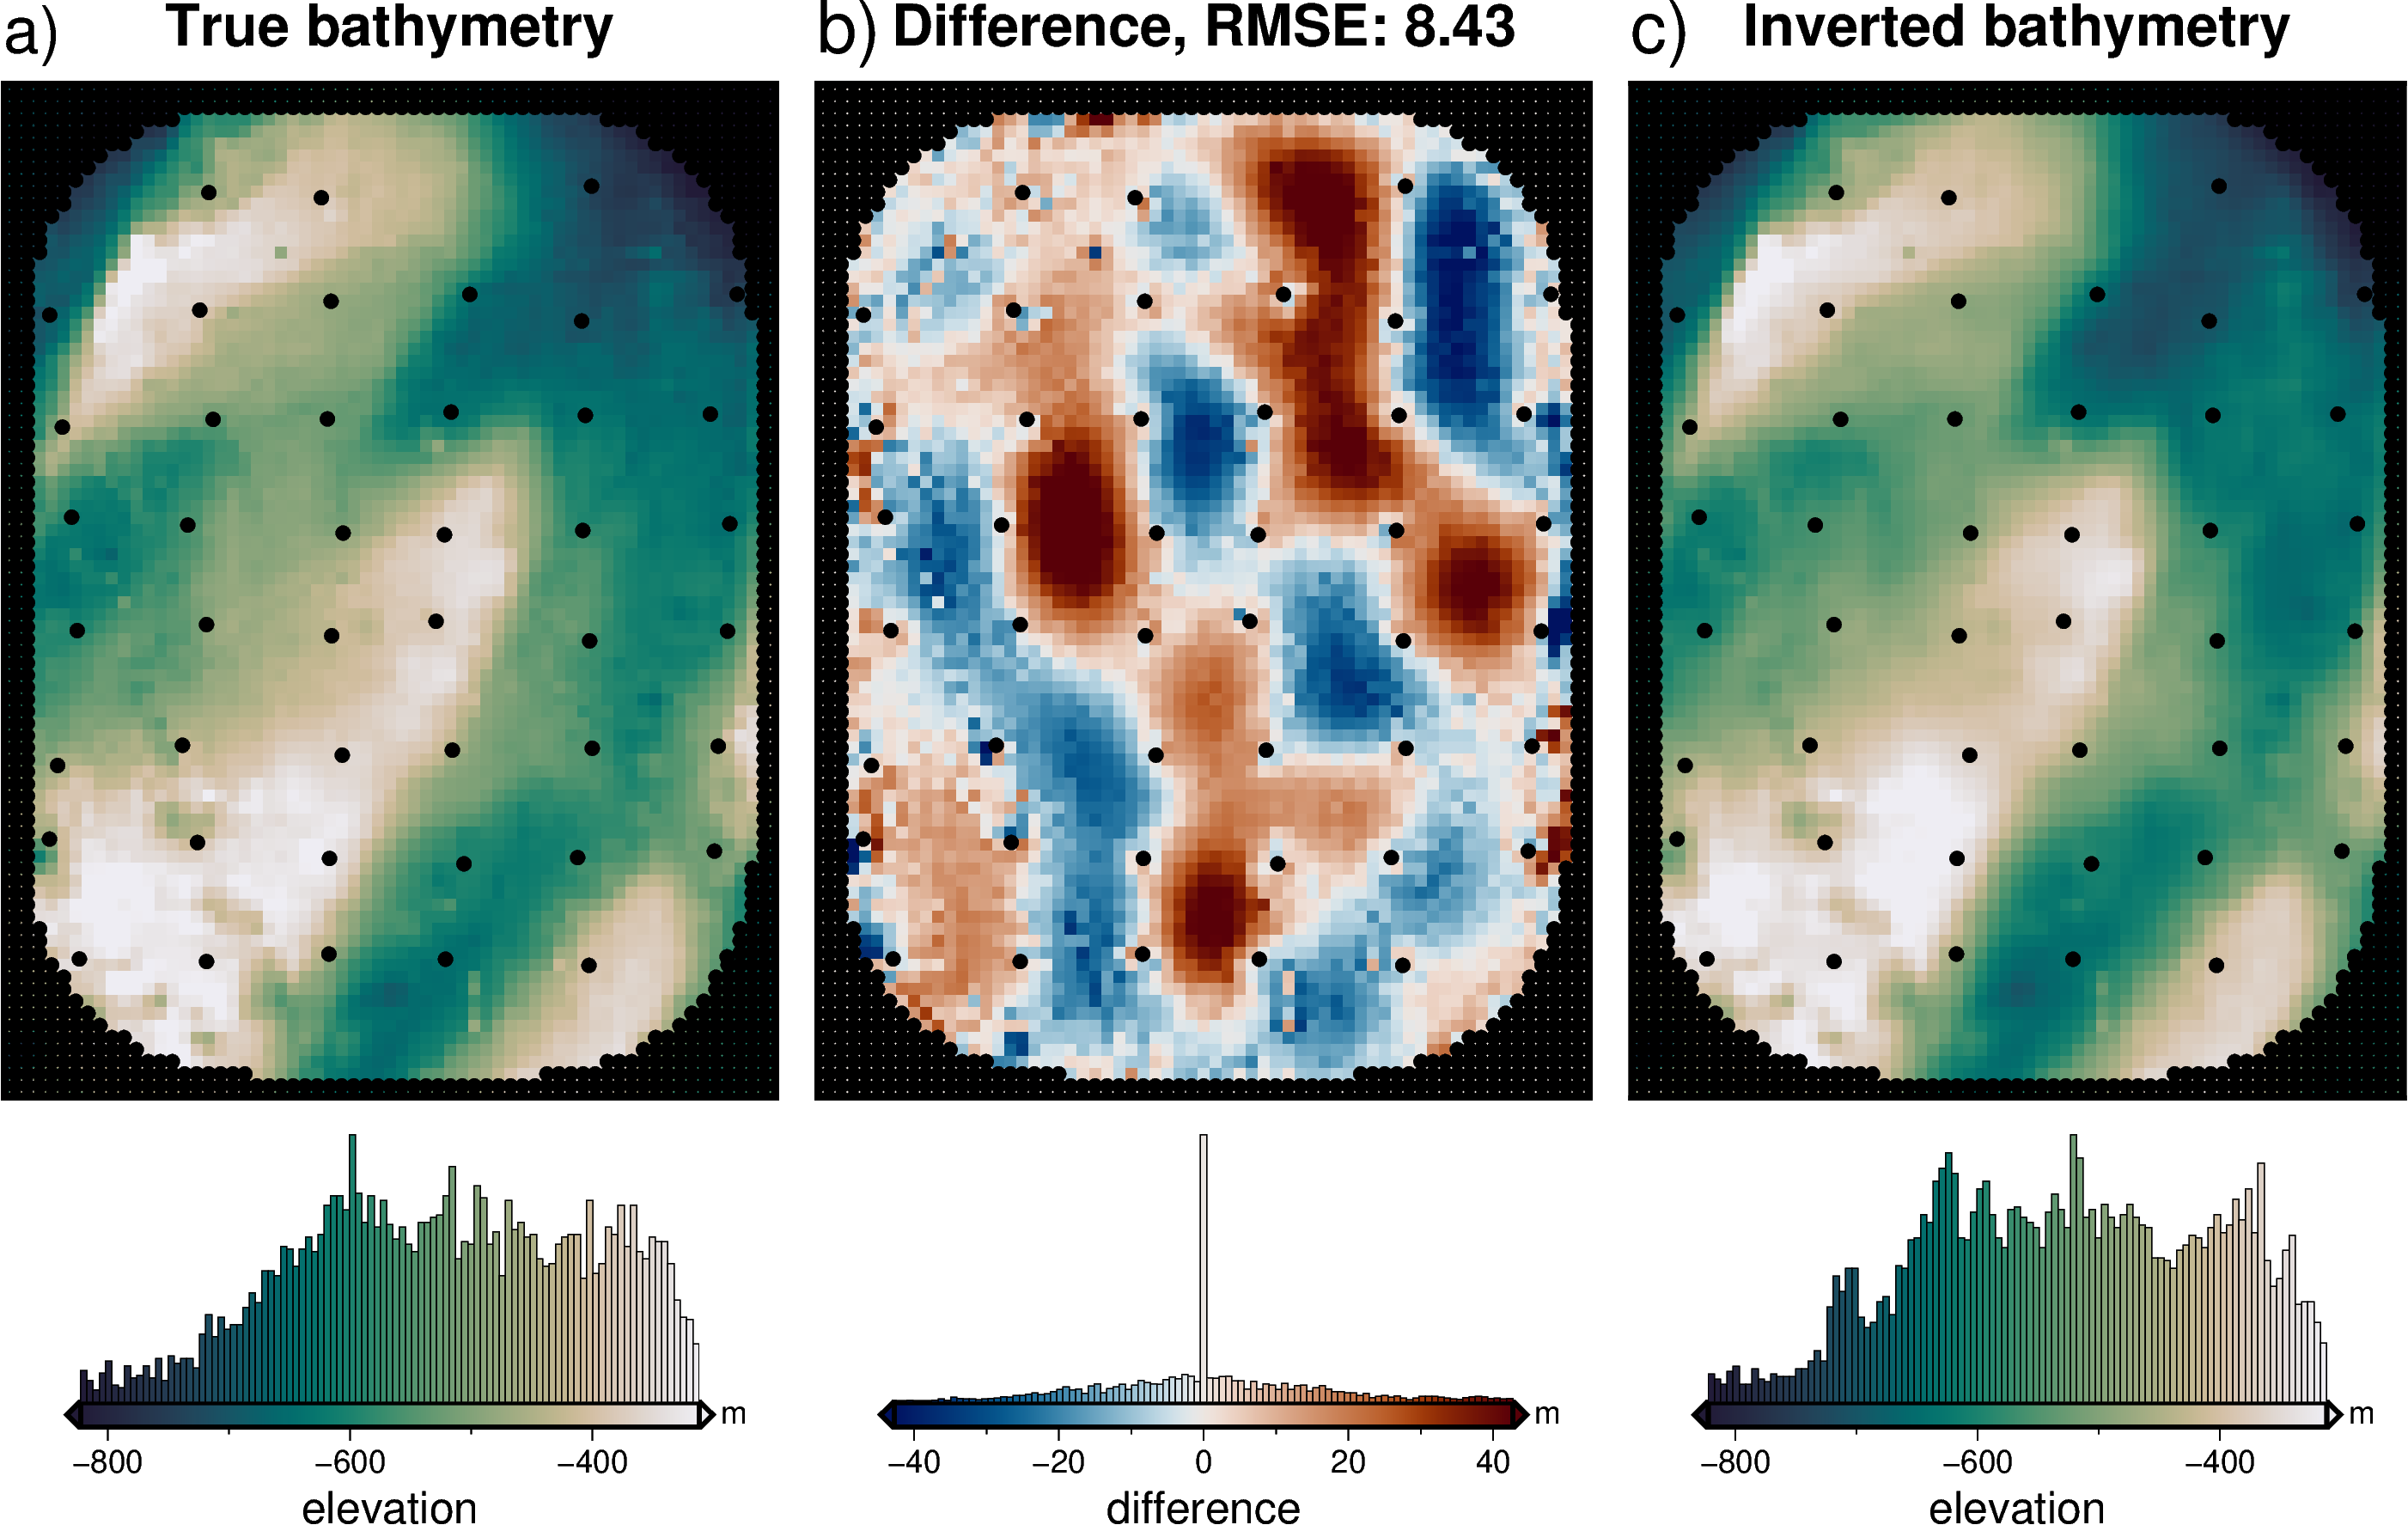

In [129]:
ds = prism_results.set_index(["northing", "easting"]).to_xarray()
cols = [s for s in prism_results.columns.to_list() if "_layer" in s]
final_bed = ds[cols[-1]]

bed_inner = bed.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)
final_bed_inner = final_bed.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)

dif = bed_inner - final_bed_inner

_ = utils.grd_compare(
    bed,
    final_bed,
    region=inversion_region,
    grid1_name="True bathymetry",
    grid2_name="Inverted bathymetry",
    title="Difference",
    title_font="16p,Helvetica-Bold",
    cbar_label="elevation",
    cbar_unit="m",
    plot=True,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    cmap="rain",
    diff_cmap="vik+h0",
    reverse_cpt=True,
    hist=True,
    inset=False,
    points_style="c.15c",
    subplot_labels=True,
    robust=True,
)

In [130]:
utils.RMSE(dif)

8.433289444185789

In [131]:
np.sqrt(np.nanmean(dif**2).item())

16.943306646841503

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [80]:
# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies,
    input_grav_column="Gobs_shift",
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.2,
    delta_l2_norm_tolerance=1.01,  # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

# set name and storage for the optimization
study_name = "Ross_Sea_inversion_params_constraints"
# study_name = "Ross_Sea_inversion_params_eq_sources"
# study_name = "Ross_Sea_inversion_params_trend"

fname = f"../optimization_logs/{study_name}.log"

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)
pathlib.Path(f"{fname}.lock").unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [81]:
# set number of runs
n_trials = 20

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
# search_space = {
#     "damping": np.arange(-4, 2, step=1, dtype="float"),
#     "weights_outer": np.arange(layer_spacing+1e3, 40e3, step=2e3, dtype="float"),
# }
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials / 3)),
        # sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
    )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    bed,
    damping_limits=[-4, 2],  # damping = 10^damping_limit
    weights_inner_limits=[layer_spacing],
    weights_outer_limits=[layer_spacing + 1e3, 40e3],
    weights_step=1e3,
    starting_prisms=starting_prisms,
    objectives=objectives,
    constraints=constraints,
    **kwargs,
)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective=objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
        parallel=True,
    )

[I 2023-04-19 18:23:47,401] A new study created in Journal with name: Ross_Sea_inversion_params_constraints


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

FrozenTrial(number=15, state=TrialState.COMPLETE, values=[35.55438119093137], datetime_start=datetime.datetime(2023, 4, 19, 18, 23, 58, 532452), datetime_complete=datetime.datetime(2023, 4, 19, 18, 24, 25, 497442), params={'damping': 0, 'weights_outer': 14000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=2, log=False, low=-4, step=1), 'weights_outer': IntDistribution(high=40000, log=False, low=6000, step=1000)}, trial_id=15, value=None)


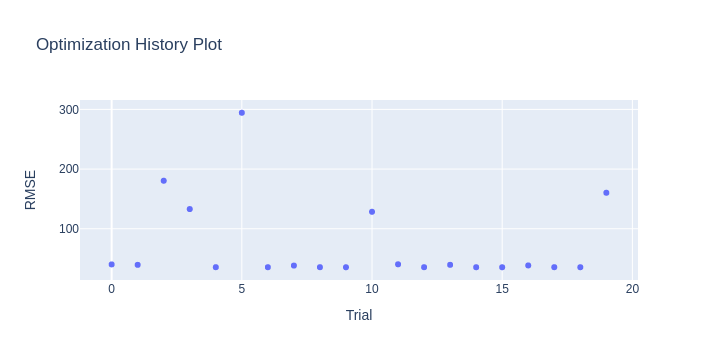

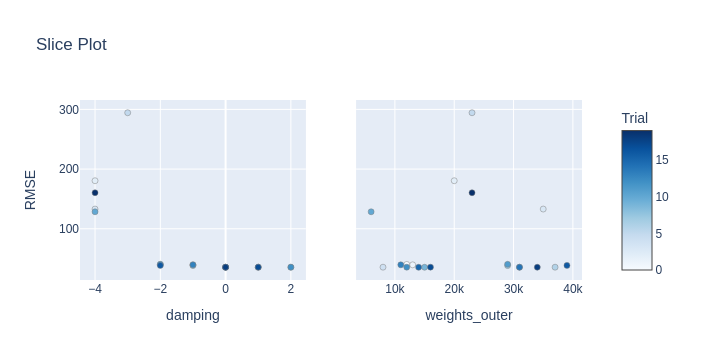

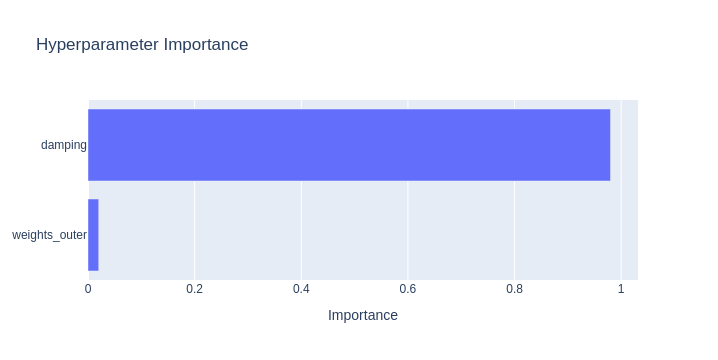

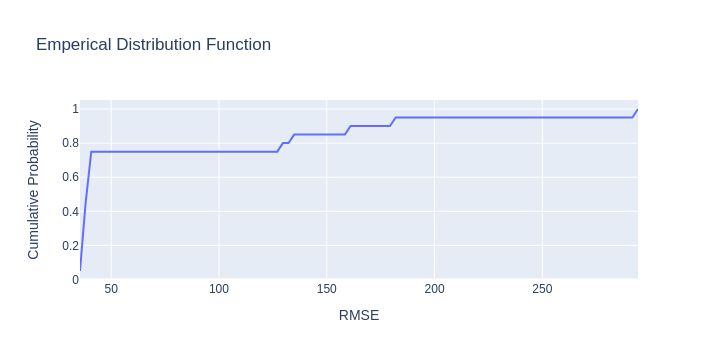

In [82]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [83]:
study.trials_dataframe().sort_values("value")

number       value             datetime_start          datetime_complete  \
15      15   35.554381 2023-04-19 18:23:58.532452 2023-04-19 18:24:25.497442   
9        9   35.555021 2023-04-19 18:23:58.352304 2023-04-19 18:24:18.411078   
14      14   35.575150 2023-04-19 18:23:58.805908 2023-04-19 18:24:23.723046   
18      18   35.593881 2023-04-19 18:23:58.631161 2023-04-19 18:24:27.702290   
4        4   35.629840 2023-04-19 18:23:59.472510 2023-04-19 18:24:21.607761   
17      17   35.629866 2023-04-19 18:23:58.927368 2023-04-19 18:24:27.169362   
6        6   35.630556 2023-04-19 18:24:00.270479 2023-04-19 18:24:13.123472   
12      12   35.630613 2023-04-19 18:23:59.734455 2023-04-19 18:24:16.028618   
8        8   35.630615 2023-04-19 18:24:01.506650 2023-04-19 18:24:19.398409   
7        7   38.361043 2023-04-19 18:24:00.126590 2023-04-19 18:26:14.498817   
16      16   38.567711 2023-04-19 18:23:59.953986 2023-04-19 18:24:44.235681   
1        1   39.594029 2023-04-19 18:23:57.988431 2023-04-19 18:26:10.573455   
13      13   39.636184 2023-04-19 18:23:58.780384 2023-04-19 18:26:16.438221   
0        0   40.286375 2023-04-19 18:23:57.626518 2023-04-19 18:24:20.059910   
11      11   40.515162 2023-04-19 18:23:59.526243 2023-04-19 18:24:32.090024   
10      10  128.480253 2023-04-19 18:23:59.212628 2023-04-19 18:24:22.803294   
3        3  133.023295 2023-04-19 18:23:59.173071 2023-04-19 18:24:42.086787   
19      19  160.337303 2023-04-19 18:23:58.970883 2023-04-19 18:24:40.068866   
2        2  180.464467 2023-04-19 18:23:58.150398 2023-04-19 18:24:30.285567   
5        5  294.361436 2023-04-19 18:23:59.687853 2023-04-19 18:24:35.951668   

                 duration  params_damping  params_weights_outer     state  
15 0 days 00:00:26.964990               0                 14000  COMPLETE  
9  0 days 00:00:20.058774               0                 15000  COMPLETE  
14 0 days 00:00:24.917138               0                 31000  COMPLETE  
18 0 days 00:00:29.071129               0                 34000  COMPLETE  
4  0 days 00:00:22.135251               1                  8000  COMPLETE  
17 0 days 00:00:28.241994               1                 16000  COMPLETE  
6  0 days 00:00:12.852993               1                 37000  COMPLETE  
12 0 days 00:00:16.294163               2                 12000  COMPLETE  
8  0 days 00:00:17.891759               2                 31000  COMPLETE  
7  0 days 00:02:14.372227              -1                 29000  COMPLETE  
16 0 days 00:00:44.281695              -2                 39000  COMPLETE  
1  0 days 00:02:12.585024              -1                 13000  COMPLETE  
13 0 days 00:02:17.657837              -1                 11000  COMPLETE  
0  0 days 00:00:22.433392              -2                 12000  COMPLETE  
11 0 days 00:00:32.563781              -2                 29000  COMPLETE  
10 0 days 00:00:23.590666              -4                  6000  COMPLETE  
3  0 days 00:00:42.913716              -4                 35000  COMPLETE  
19 0 days 00:00:41.097983              -4                 23000  COMPLETE  
2  0 days 00:00:32.135169              -4                 20000  COMPLETE  
5  0 days 00:00:36.263815              -3                 23000  COMPLETE

In [86]:
df = study.trials_dataframe().sort_values(by="value").loc[7]
params = {"damping": df.params_damping.item(), "weights_outer": df.params_weights_outer}

# params = study.best_params

params

{'damping': -1, 'weights_outer': 29000}

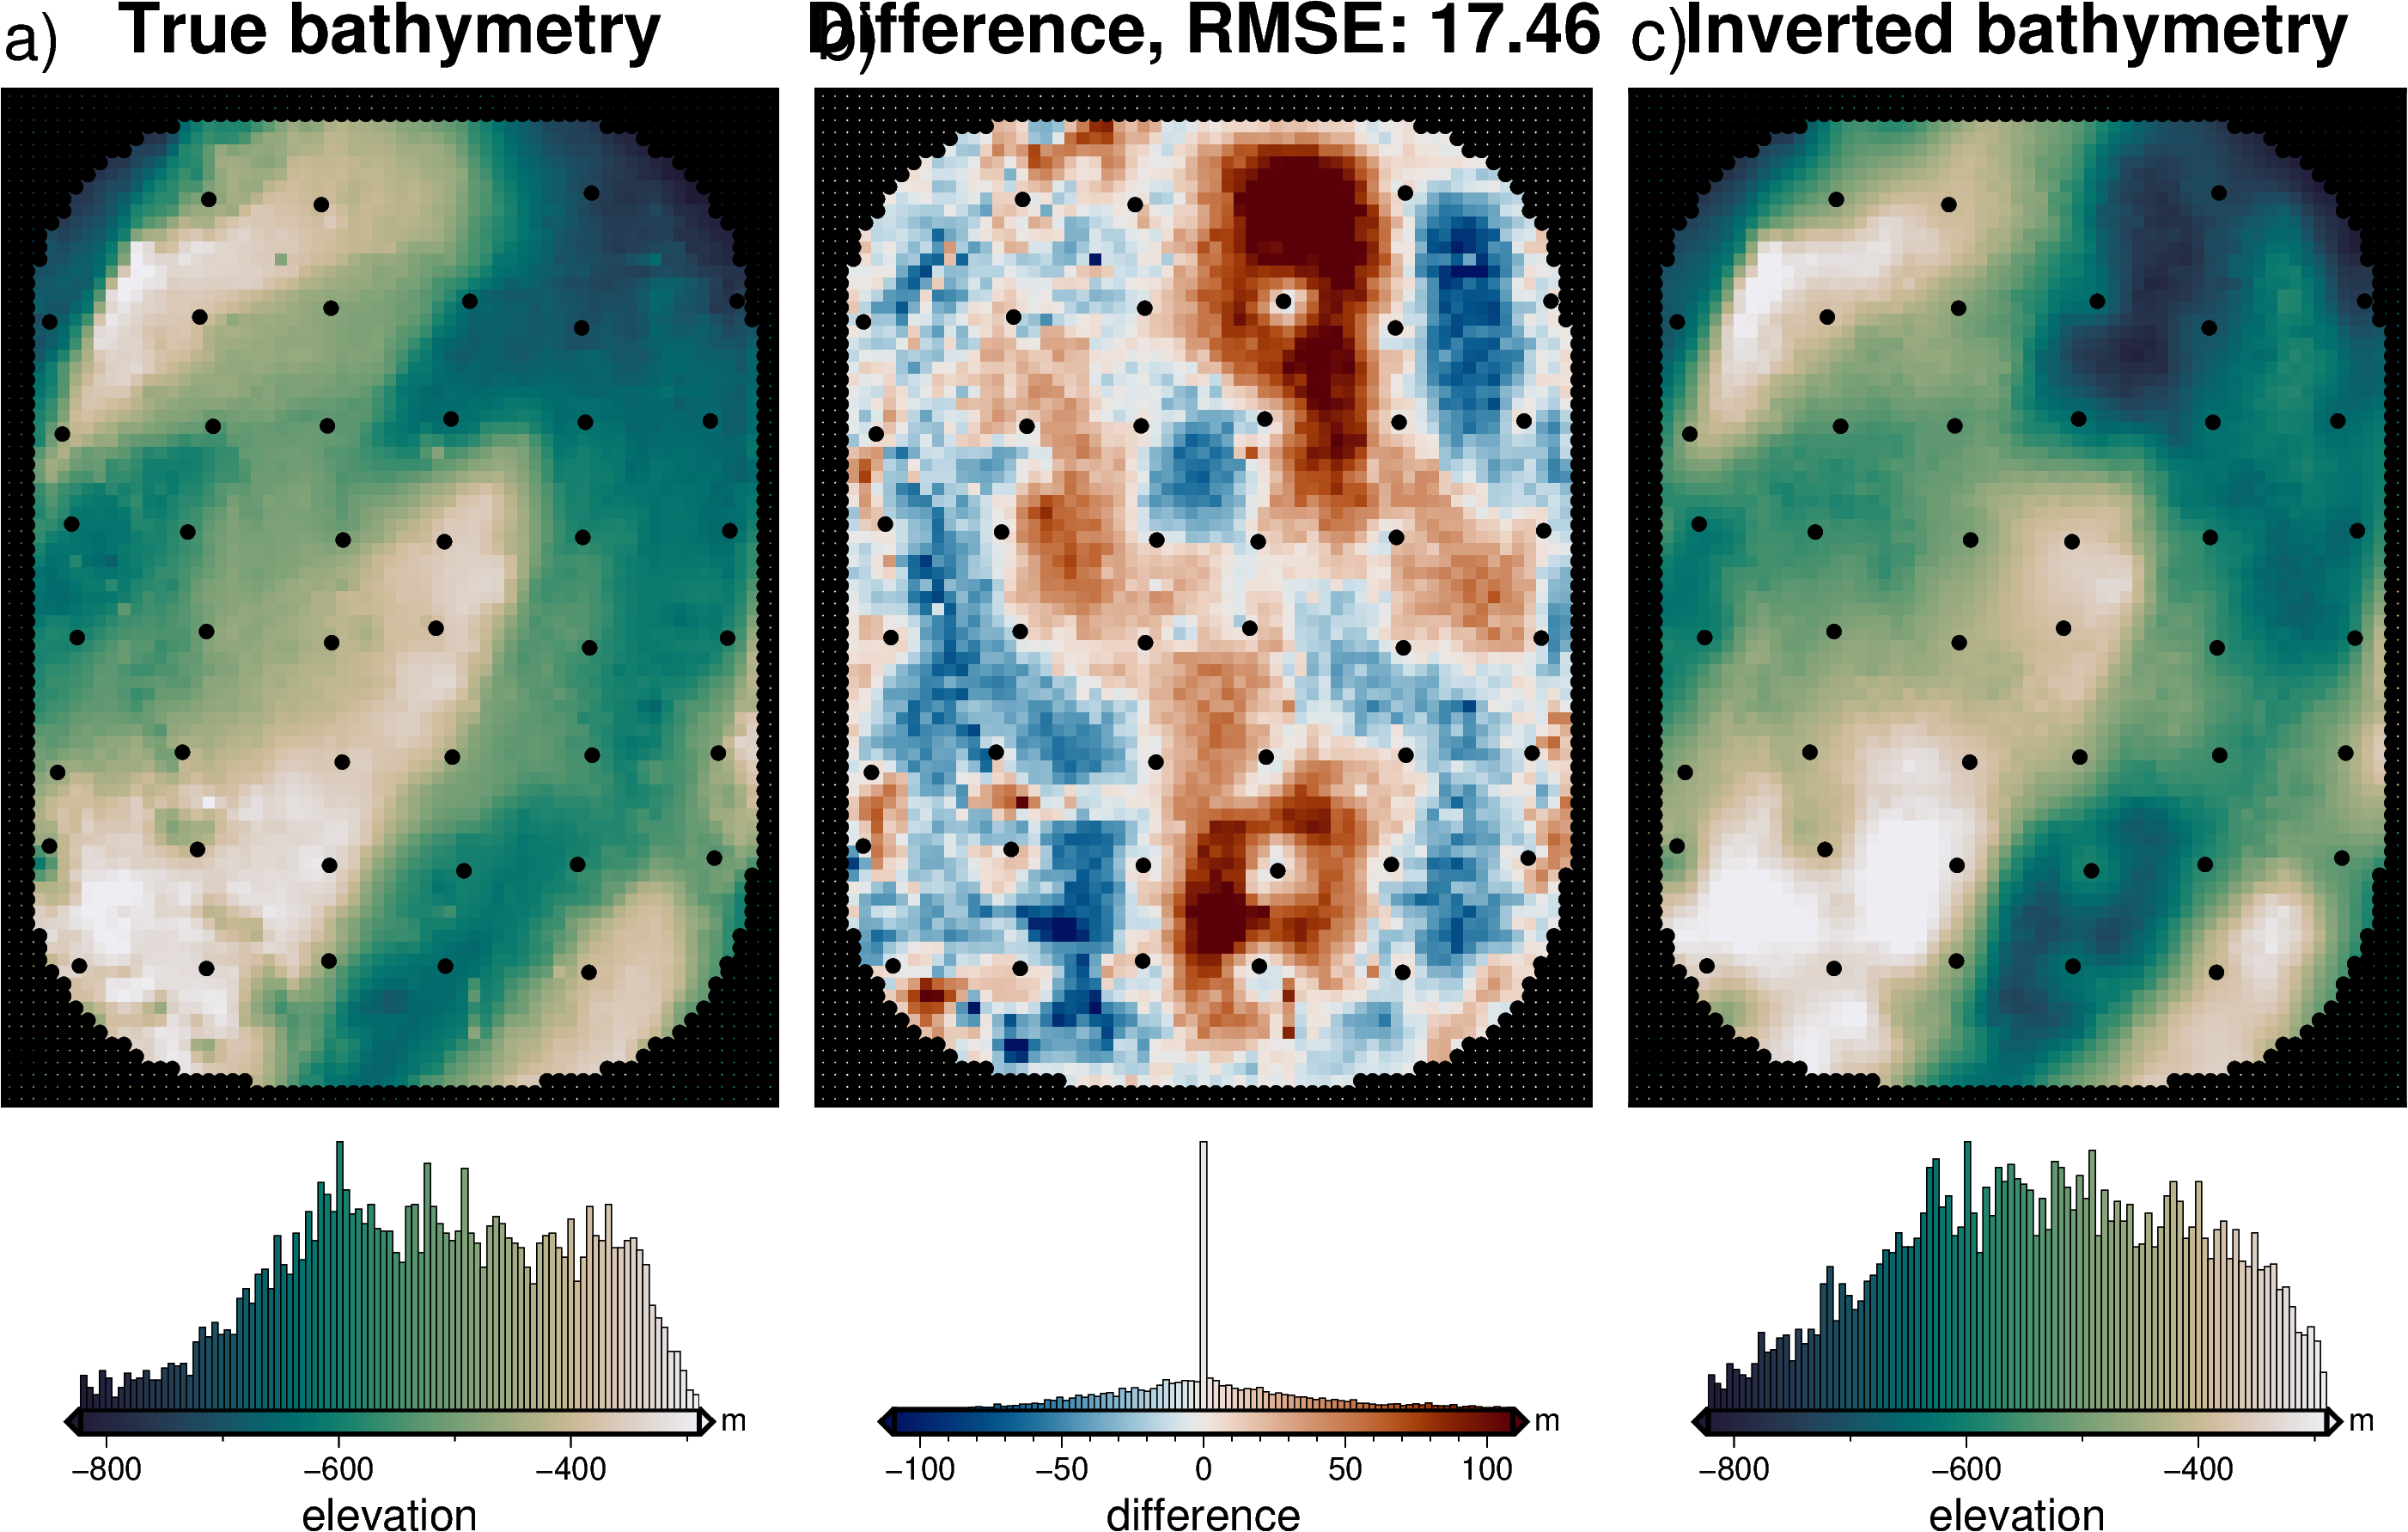

RMSE between surfaces at constraints: 0.0 m


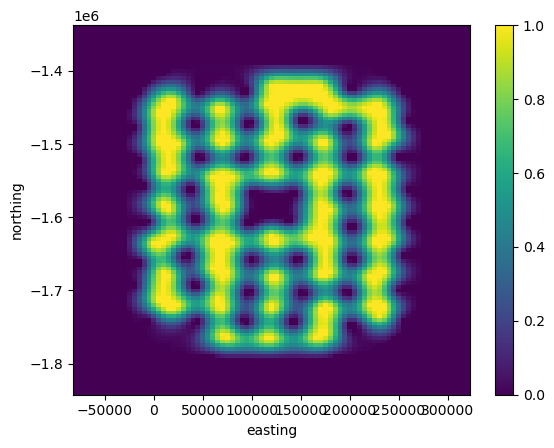

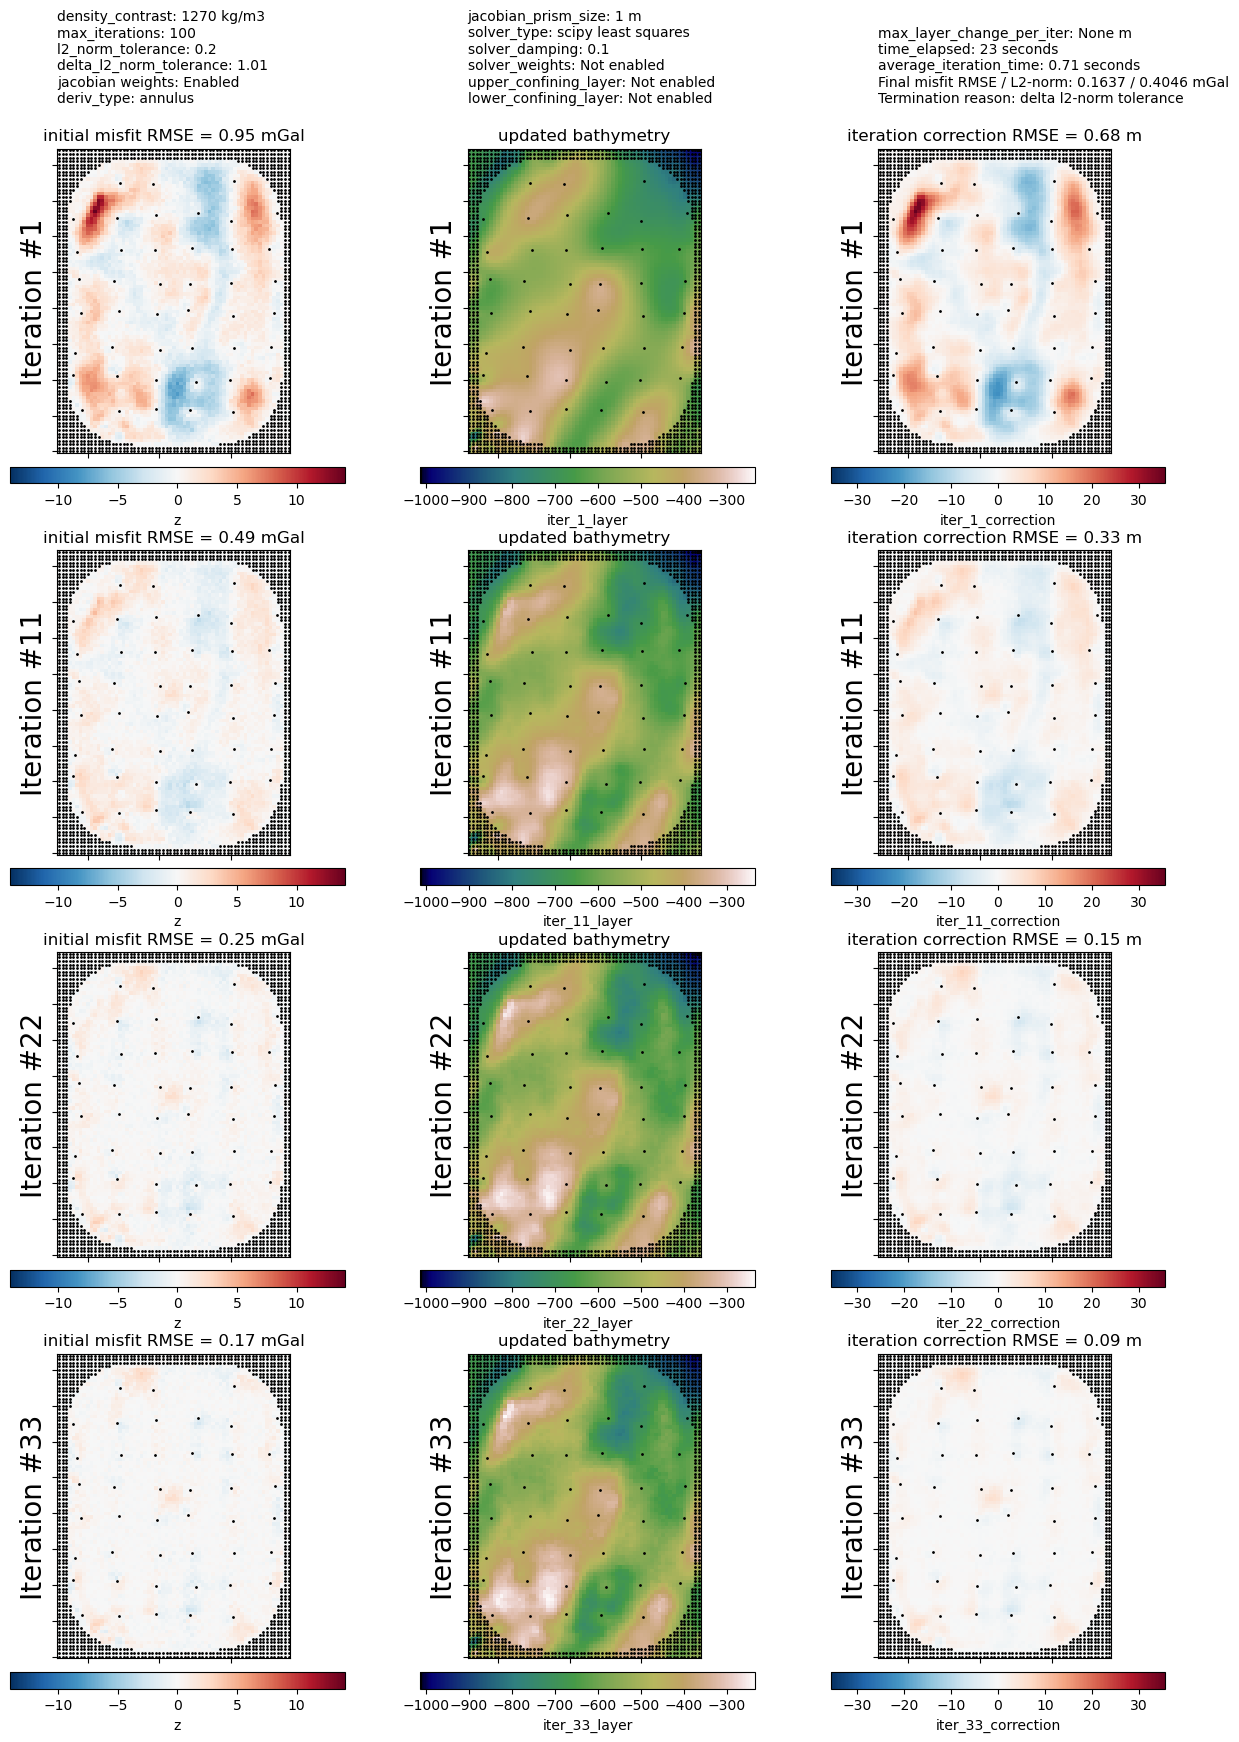

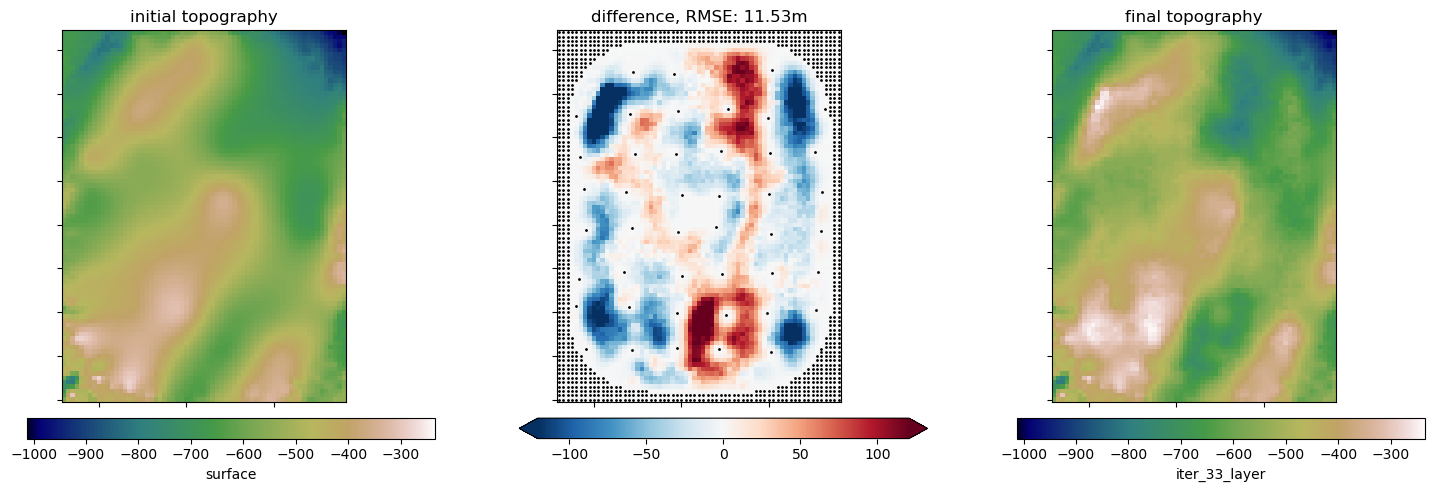

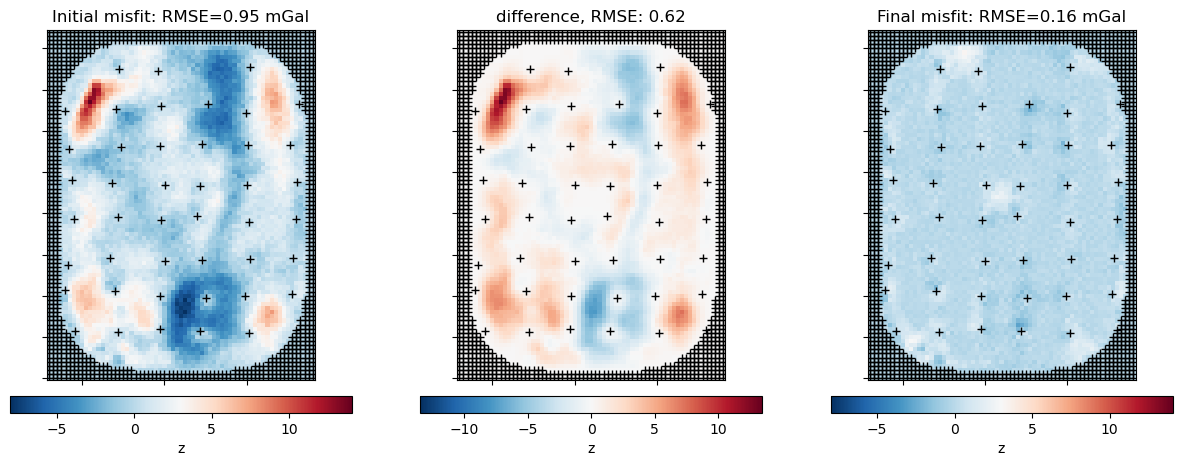

In [87]:
# params = {'damping': -1, 'weights_outer': 35000}

weights, _ = inv_utils.constraints_grid(
    constraints,
    starting_prisms.drop("weights"),
    inner_bound=layer_spacing,
    outer_bound=params["weights_outer"],
    low=0,
    high=1,
    region=inversion_region,
    interp_type="spline",
)
weights.plot()
starting_prisms["weights"] = weights

plotting.plot_best_inversion(
    true_surface=bed,
    prism_layer=starting_prisms,
    best_params=params,
    grav_spacing=grav_spacing,
    constraint_points=constraints,
    plot_type="pygmt",
    robust=True,
    **kwargs,
)